In [2]:
machine = 'mac'
machine = 'magny'

In [3]:
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
    
file = filedir + 'potential_params_10000_with_initeqbestfit.txt'

dopotfit = False

In [4]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np
from scipy import optimize as opt

from astropy import units

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm


from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import datetime
import random

%matplotlib inline

With eat_snap_and_fof we can read in simulations from snapnr 3.

Number of DM particles (does not change during simulation run): 34,898,087

Let's take a random sample which makes $0.5\%$:

$0.005 \cdot 34898087 \approx 175000$



In [5]:
#_____reference values for galpy_____
_REFR0_kpc = 8.

#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB)
    return [disk, halo, bulge]


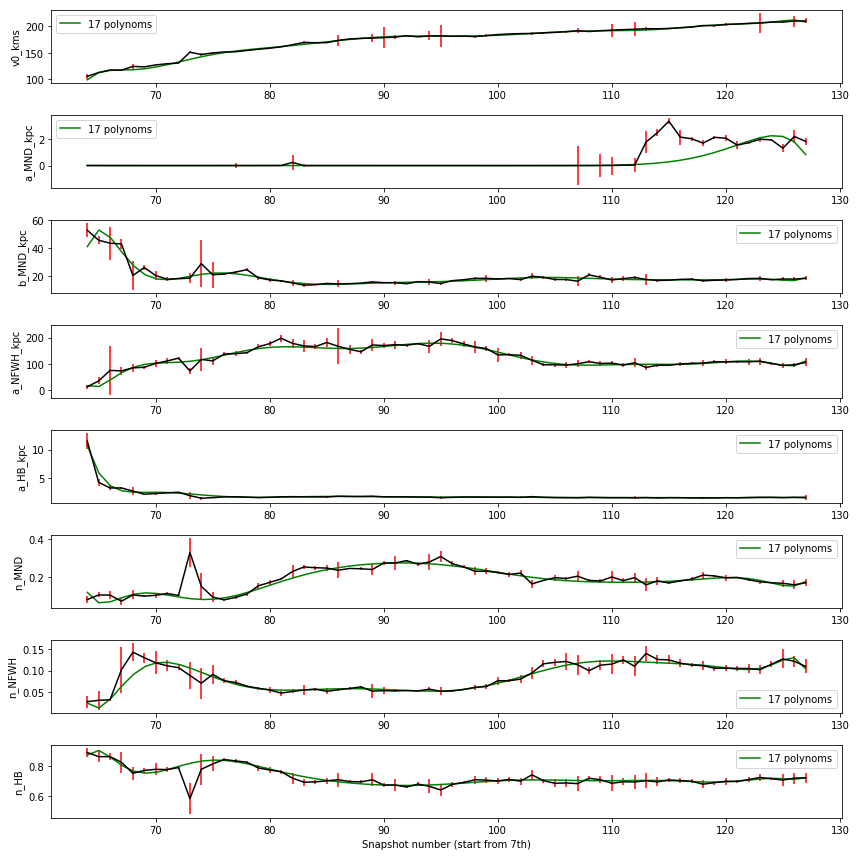

In [6]:
pot_params = np.loadtxt(file)
# wenn dann das file richtig ist funktioniert folgendes (hoffentlich):

snapnr          = pot_params[:,0]
v0_kms          = pot_params[:,1]
v0_kms_err      = pot_params[:,2]
a_MND_kpc       = pot_params[:,3]
a_MND_kpc_err   = pot_params[:,4]
b_MND_kpc       = pot_params[:,5]
b_MND_kpc_err   = pot_params[:,6]
a_NFWH_kpc      = pot_params[:,7]
a_NFWH_kpc_err  = pot_params[:,8]
a_HB_kpc        = pot_params[:,9]
a_HB_kpc_err    = pot_params[:,10]
n_MND           = pot_params[:,11]
n_MND_err       = pot_params[:,12]
n_NFWH          = pot_params[:,13]
n_NFWH_err      = pot_params[:,14]
n_HB            = pot_params[:,15]
n_HB_err        = pot_params[:,16]

snapnr = np.array(snapnr, dtype = int)


'''
ndim = 7
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]

f, axes = plt.subplots(7, 2, figsize=(12,12))

params = np.vstack([v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB])
params_err = np.vstack([v0_kms_err, a_MND_kpc_err, b_MND_kpc_err, a_NFWH_kpc_err, a_HB_kpc_err, n_MND_err, n_NFWH_err, n_HB_err])
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,0].set_xlabel('Snapshot number')
    axes[ii,0].set_ylabel(labels[ii])
    axes[ii,0].errorbar(snapnr, params[ii],yerr= params_err[ii], color='k', ecolor='r')    
    axes[ii,0].set_yscale('log', nonposy="clip")
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,1].set_xlabel('Snapshot number (start from 7th)')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii,1].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
f.tight_layout()
#f.savefig(plotdir + 'parameter_evolution_1000steps.png', dpi = 300, bbox_inches = 'tight', format = 'png')
'''

ndim = 8
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]

err_res = []
params = np.vstack([v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB])
params_err = np.vstack([v0_kms_err, a_MND_kpc_err, b_MND_kpc_err, a_NFWH_kpc_err, a_HB_kpc_err, n_MND_err, n_NFWH_err, n_HB_err])
'''
for jj in range(20):
    f, axes = plt.subplots(ndim, 1, figsize=(12,12))
    for ii in range(ndim):
        axes[ii].set_ylabel(labels[ii])
        if ii == (ndim - 1):
            axes[ii].set_xlabel('Snapshot number (start from 7th)')
        #axes[ii,1].set_ylabel(labels[ii])
        axes[ii].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
        #axes[ii,1].set_yscale('log', nonposy="clip")
        zz = np.polyfit(snapnr[4:], params[ii][4:], jj+1, w = (1./params_err[ii][4:]), full = True)
        #print("\nPolyfit result of " + labels[ii]  + " for " + str (jj + 1) + ' polynoms:\n')
        #print(zz[0])
        #print('\nresiduals, rank, singular_values, rcond:\n')
        #print(zz[1:])
        #print(zz[1])
        if len(zz[1]) == 0:
            continue
        else:
                
            err_res.append(zz[1])
            p = np.poly1d(zz[0])
            xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
            axes[ii].plot(xp, p(xp), 'g-', label = str(jj + 1) + ' polynoms')
            axes[ii].legend()
    f.tight_layout()
err_Res = np.reshape(np.array(err_res), (int(len(err_res)/ndim),ndim))
print(err_Res)
print(np.amin(err_Res, axis = 0))
'''    
    #display(f)
#f.savefig(plotdir + 'parameter_evolution_1000steps_lin_start7.png', dpi = 300, bbox_inches = 'tight', format = 'png')

jj = 17

fitted_params = []
f, axes = plt.subplots(ndim, 1, figsize=(12,12))
for ii in range(ndim):
    axes[ii].set_ylabel(labels[ii])
    if ii == (ndim - 1):
        axes[ii].set_xlabel('Snapshot number (start from 7th)')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    p = np.poly1d(zz[0])
    xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    axes[ii].legend()
    fitted_params.append(p(xp))
f.tight_layout()

fitted_params = np.array(fitted_params)
#keep normalization of n_vals"
normfac = (fitted_params[5] + fitted_params[6] + fitted_params[7])
fitted_params[5] = fitted_params[5] / normfac
fitted_params[6] = fitted_params[6] / normfac
fitted_params[7] = fitted_params[7] / normfac


#fitted_params.reshape(int(len(fitted_params)/7),7)
    #display(f)
#f.savefig(plotdir + 'parameter_evolution_lin_'+ str(jj)+'polynomsfit.png', dpi = 300, bbox_inches = 'tight', format = 'png')

In [7]:
def dens(M, R_kpc, z_kpc, dR_kpc, dz_kpc):
    
    Rmin_kpc, Rmax_kpc = np.min(R_kpc), np.max(R_kpc)
    zmin_kpc, zmax_kpc = np.min(z_kpc), np.max(z_kpc)


    Rbins, zbins = np.arange(Rmin_kpc, Rmax_kpc, dR_kpc), np.arange(zmin_kpc, zmax_kpc, dz_kpc)
    mbins, volbins = np.zeros((len(zbins), len(Rbins))), np.zeros((len(zbins), len(Rbins))) 
    for i in range(len(zbins)):
        for j in range(len(Rbins)):
            inbin = (Rbins[j] <= R_kpc) & (R_kpc < (Rbins[j] + dR_kpc)) & (zbins[i] <= z_kpc) & (z_kpc < (zbins[i] + dz_kpc))
            mbins[i,j] = np.sum(M[inbin])
            volbins[i,j] = np.pi * dz_kpc * (2. * Rbins[j] * dR_kpc + dR_kpc**2)
       
    rho = mbins / volbins
    return(rho, Rbins, zbins, volbins)


snapnr: 75
22:03:07.821751
[ 16.16160011  15.58262157  16.72860718]
calculate galpy potentials


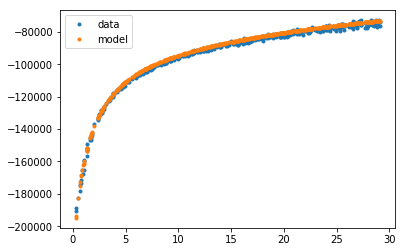

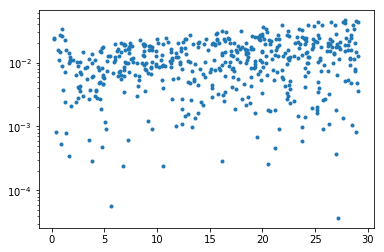

snapnr: 76
22:03:28.192134
[ 16.47659492  15.88422775  17.06827354]
calculate galpy potentials


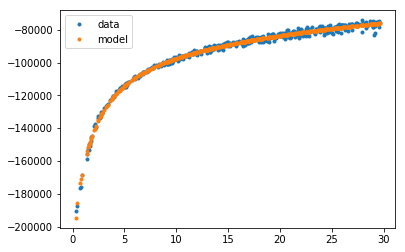

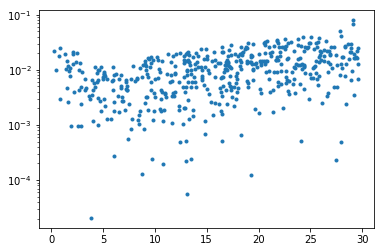

snapnr: 77
22:03:47.693762
[ 16.79800034  16.19346237  17.41295624]
calculate galpy potentials


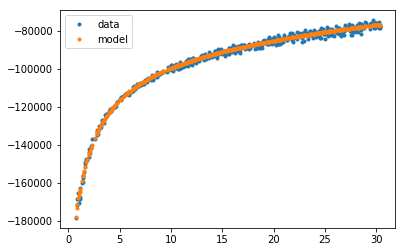

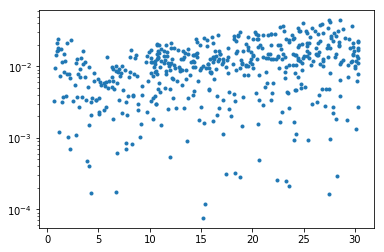

snapnr: 78
22:04:06.460945
[ 17.20534706  16.5902729   17.85304451]
calculate galpy potentials


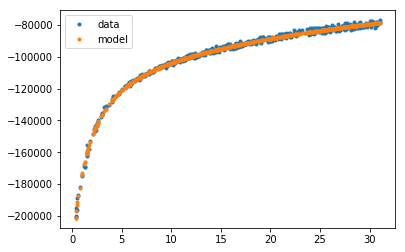

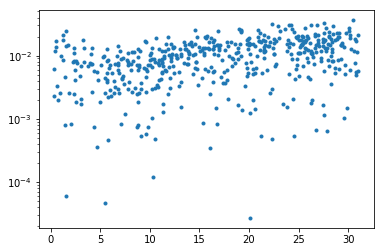

snapnr: 79
22:04:25.766471
[ 17.53638649  16.91461563  18.2147541 ]
calculate galpy potentials


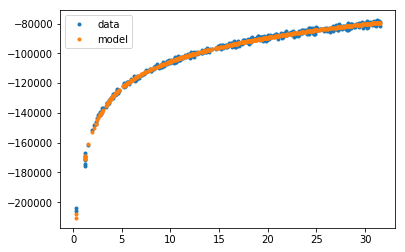

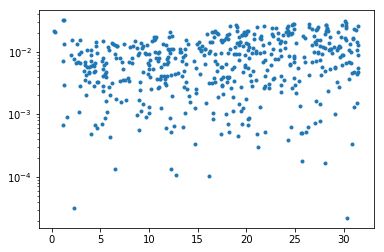

snapnr: 80
22:04:44.886782
[ 17.78905106  17.16118431  18.49117279]
calculate galpy potentials


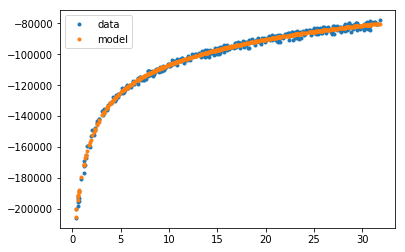

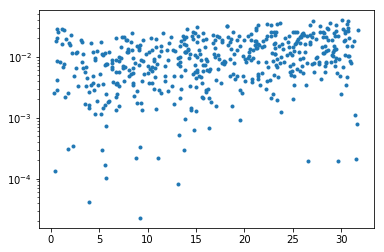

snapnr: 81
22:05:03.333378
[ 18.13132668  17.49447441  18.86812019]
calculate galpy potentials


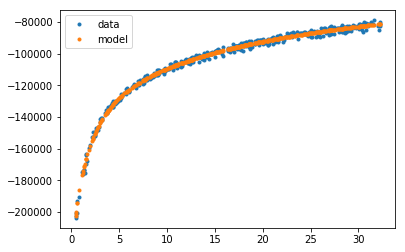

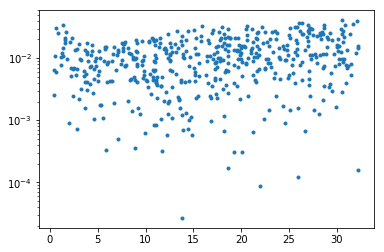

snapnr: 82
22:05:22.250956
[ 18.48038101  17.83345413  19.25479507]
calculate galpy potentials


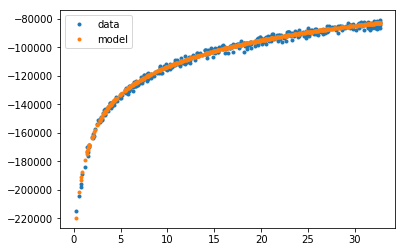

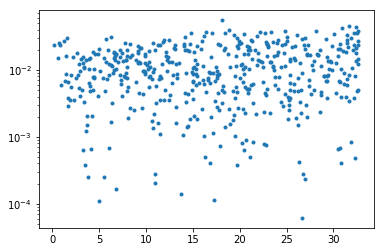

snapnr: 83
22:05:42.797908
[ 18.83633041  18.17889214  19.65101624]
calculate galpy potentials


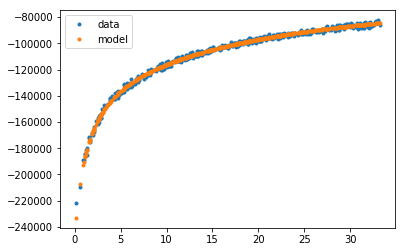

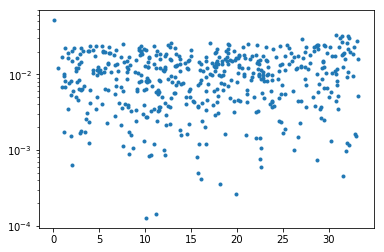

snapnr: 84
22:06:03.570800
[ 19.10744095  18.44243622  19.95356178]
calculate galpy potentials


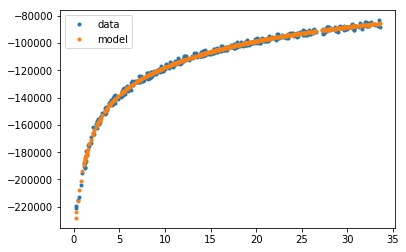

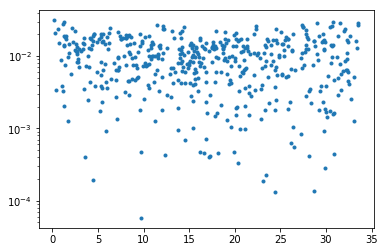

snapnr: 85
22:06:23.231543
[ 19.47507477  18.79951668  20.36402512]
calculate galpy potentials


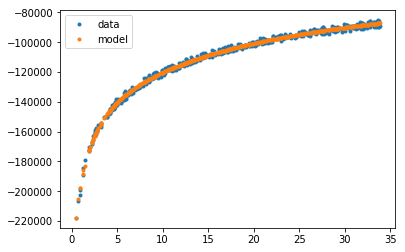

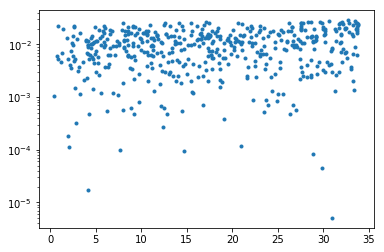

snapnr: 86
22:06:44.956930
[ 19.75509262  19.0717144   20.67724609]
calculate galpy potentials


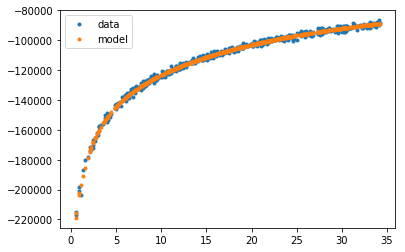

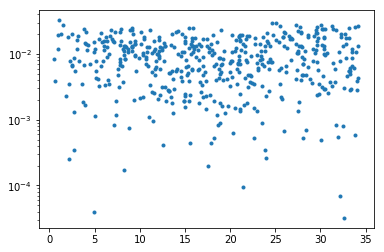

snapnr: 87
22:07:05.307898
[ 20.13412285  19.44070625  21.10229874]
calculate galpy potentials


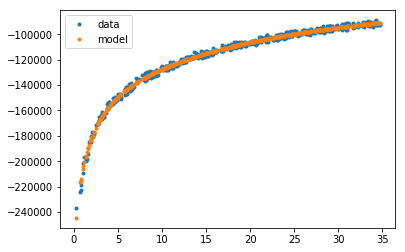

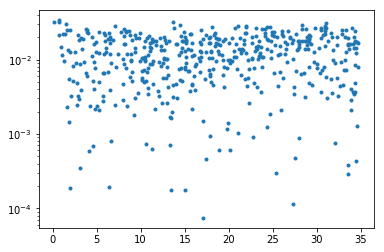

snapnr: 88
22:07:26.156021
[ 20.42412758  19.72184372  21.42675972]
calculate galpy potentials


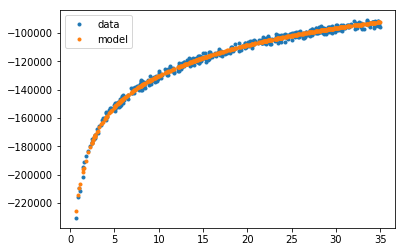

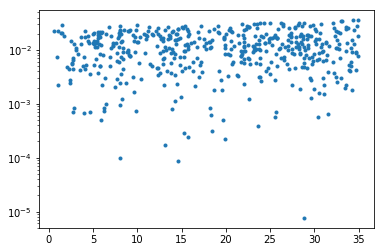

snapnr: 89
22:07:46.608178
[ 20.81840324  20.10211563  21.86827469]
calculate galpy potentials


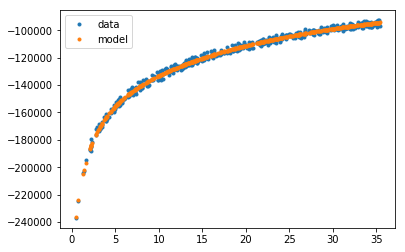

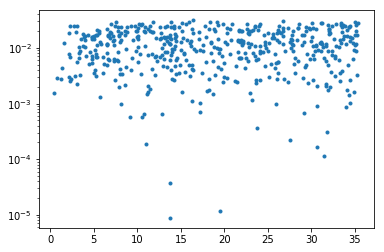

snapnr: 90
22:08:07.216498
[ 21.11937714  20.39230919  22.20462799]
calculate galpy potentials


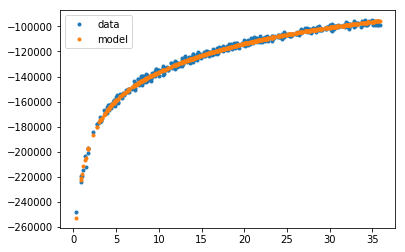

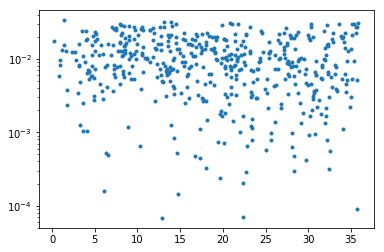

snapnr: 91
22:08:26.838249
[ 21.42389488  20.68611908  22.54693604]
calculate galpy potentials


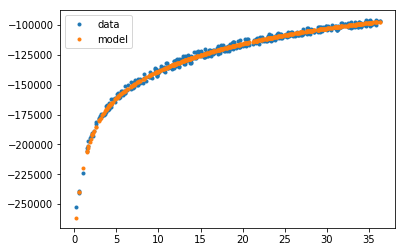

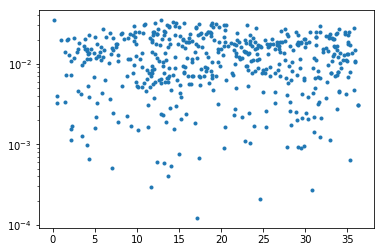

snapnr: 92
22:08:48.138582
[ 21.73373222  20.98360252  22.89403915]
calculate galpy potentials


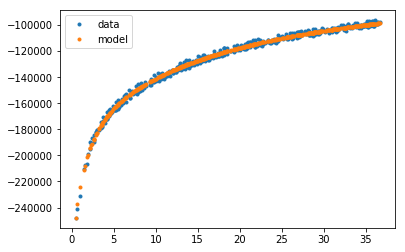

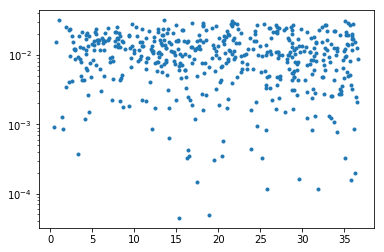

snapnr: 93
22:09:08.423906
[ 22.153759    21.38641167  23.364851  ]
calculate galpy potentials


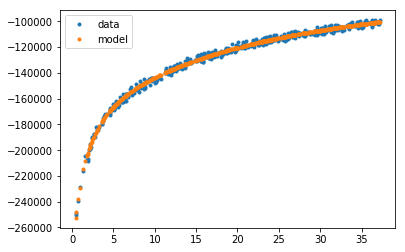

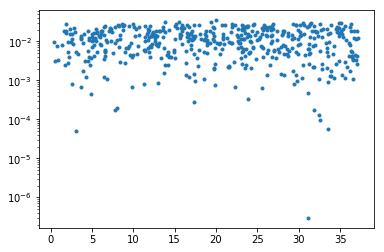

snapnr: 94
22:09:29.879354
[ 22.47373009  21.69274902  23.72468185]
calculate galpy potentials


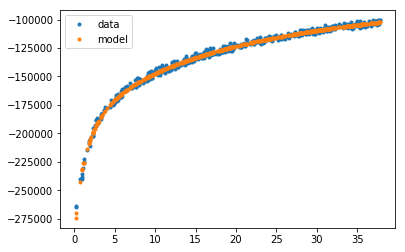

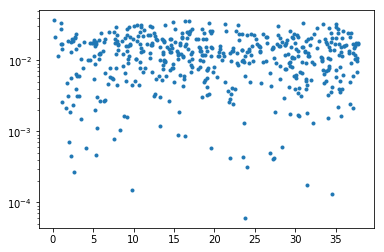

snapnr: 95
22:09:49.439818
[ 22.7996521   22.0025444   24.08984756]
calculate galpy potentials


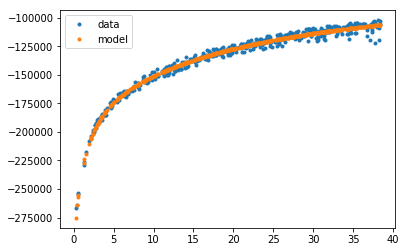

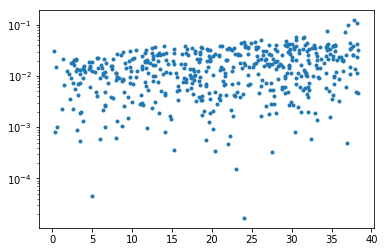

snapnr: 96
22:10:10.844312
[ 23.13161278  22.31706619  24.45867538]
calculate galpy potentials


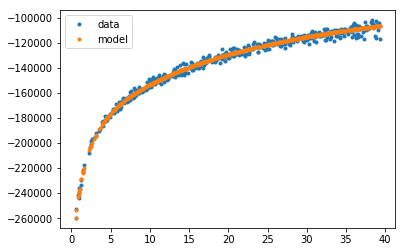

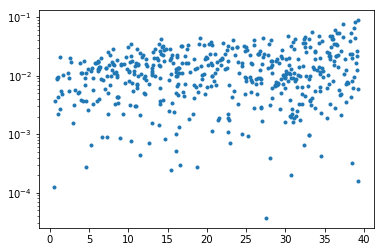

snapnr: 97
22:10:30.974395
[ 23.46821594  22.63773918  24.8325634 ]
calculate galpy potentials


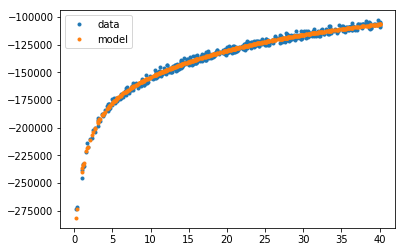

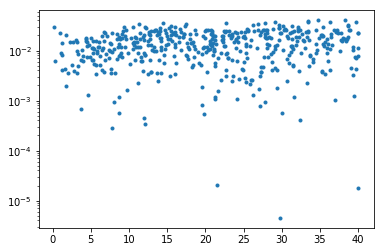

snapnr: 98
22:10:52.065411
[ 23.80860329  22.96368408  25.21352386]
calculate galpy potentials


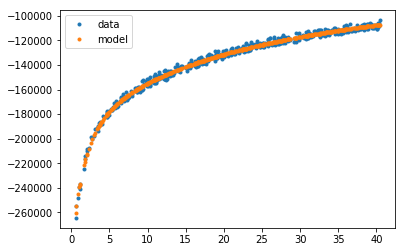

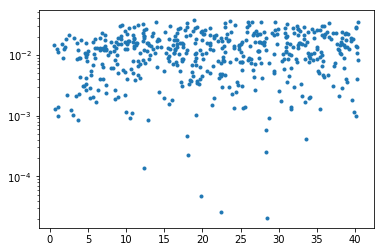

snapnr: 99
22:11:12.592974
[ 24.15342522  23.29395103  25.60112953]
calculate galpy potentials


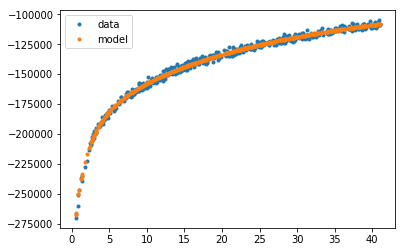

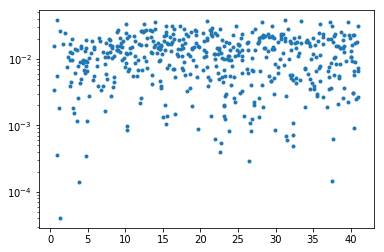

snapnr: 100
22:11:33.682082
[ 24.50271797  23.62892342  25.99520683]
calculate galpy potentials


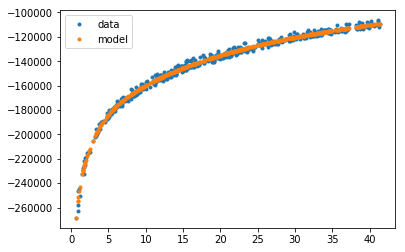

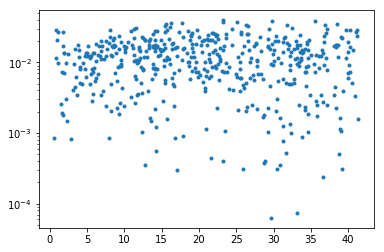

snapnr: 101
22:11:54.142499
[ 24.85713387  23.96839905  26.39595032]
calculate galpy potentials


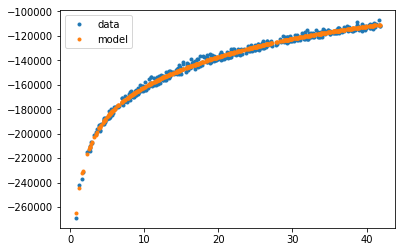

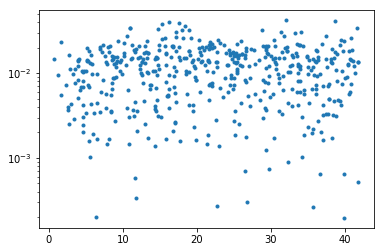

snapnr: 102
22:12:15.226322
[ 25.21674347  24.31293106  26.80324364]
calculate galpy potentials


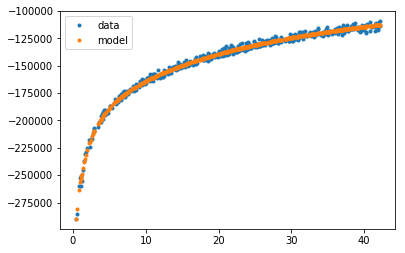

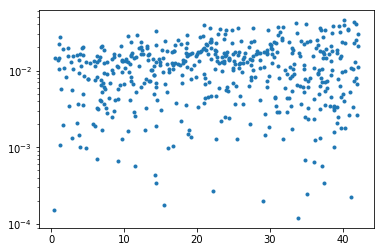

snapnr: 103
22:12:35.318393
[ 25.45941925  24.54529381  27.07883453]
calculate galpy potentials


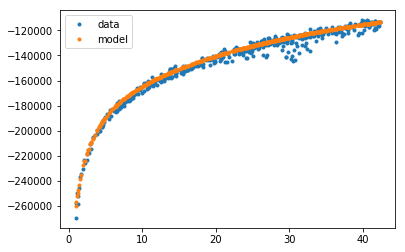

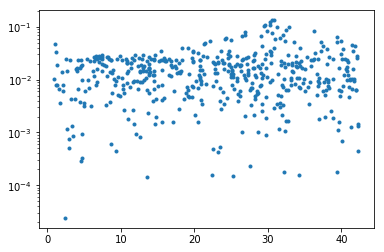

snapnr: 104
22:12:57.254957
[ 25.82858849  24.89687347  27.49774933]
calculate galpy potentials


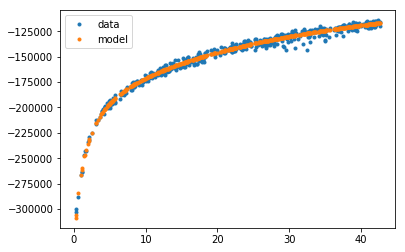

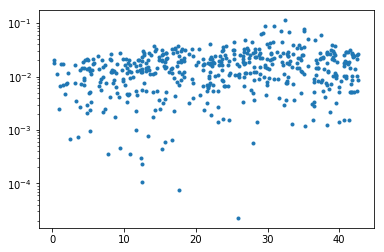

snapnr: 105
22:13:17.955404
[ 26.2042942   25.2542057   27.92131042]
calculate galpy potentials


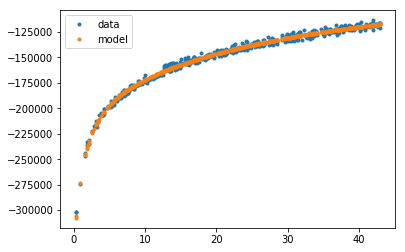

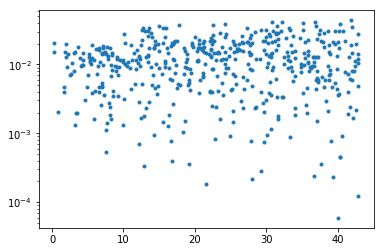

snapnr: 106
22:13:39.735624
[ 26.58517647  25.61821175  28.35095024]
calculate galpy potentials


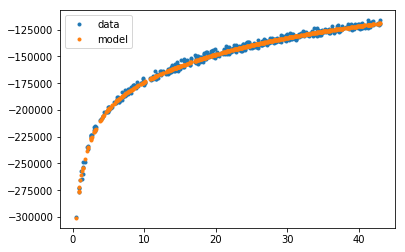

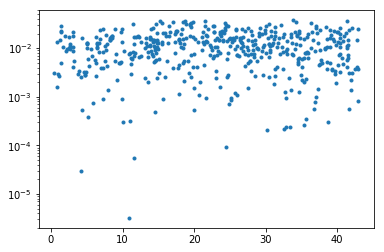

snapnr: 107
22:14:00.266943
[ 26.97145081  25.98770905  28.78736305]
calculate galpy potentials


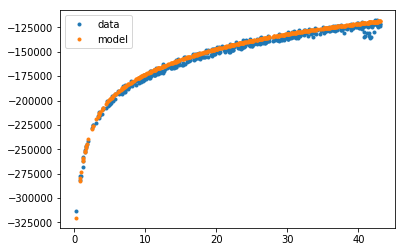

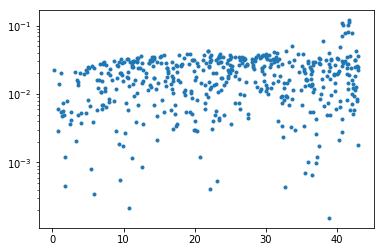

snapnr: 108
22:14:21.825314
[ 27.23214722  26.23708725  29.08192825]
calculate galpy potentials


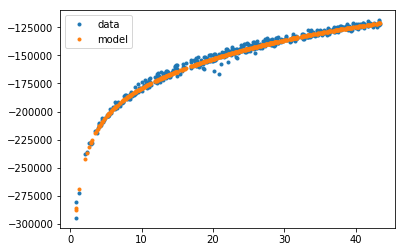

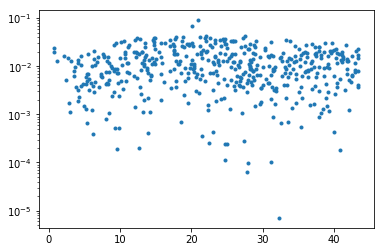

snapnr: 109
22:14:41.735779
[ 27.62681198  26.61546135  29.52968025]
calculate galpy potentials


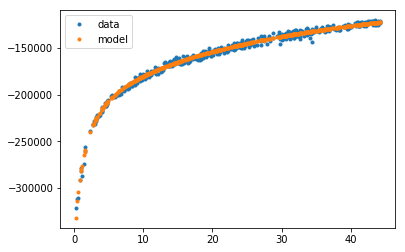

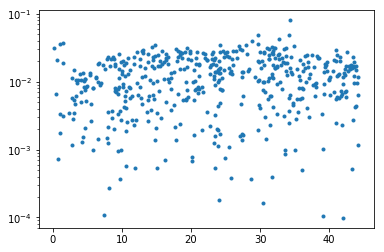

snapnr: 110
22:15:03.316524
[ 28.02821541  26.99830246  29.98339081]
calculate galpy potentials


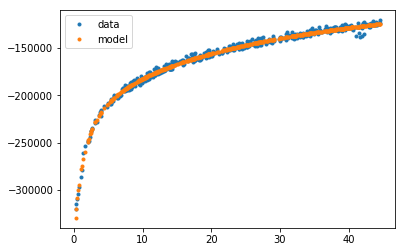

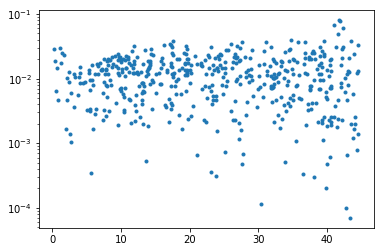

snapnr: 111
22:15:23.837321
[ 28.29884148  27.25717163  30.28975487]
calculate galpy potentials


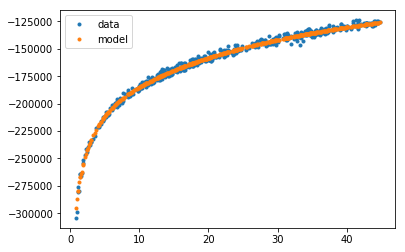

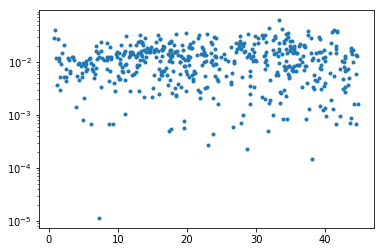

snapnr: 112
22:15:45.589931
[ 28.71037102  27.65019417  30.75450516]
calculate galpy potentials


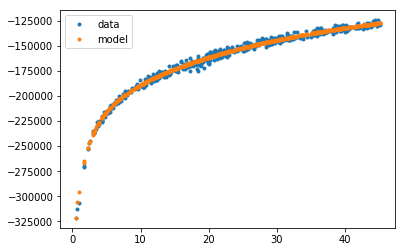

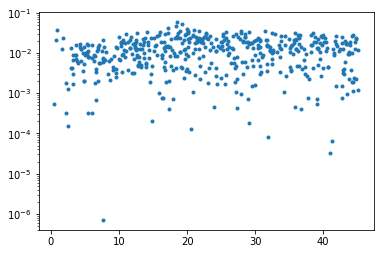

snapnr: 113
22:16:06.619430
[ 29.12677383  28.04948807  31.22624779]
calculate galpy potentials


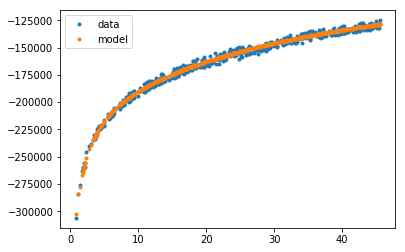

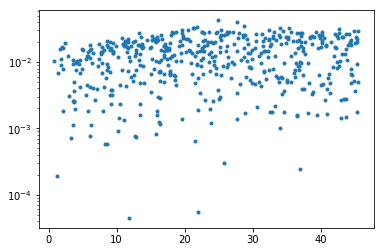

snapnr: 114
22:16:27.467282
[ 29.40730476  28.31895065  31.54471207]
calculate galpy potentials


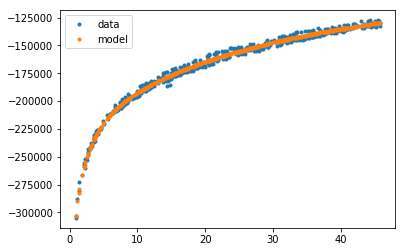

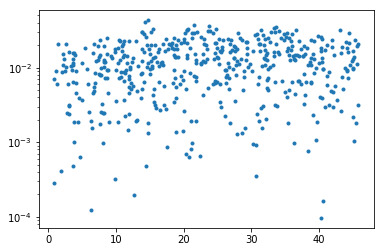

snapnr: 115
22:16:48.391011
[ 29.83269691  28.72842789  32.02832794]
calculate galpy potentials


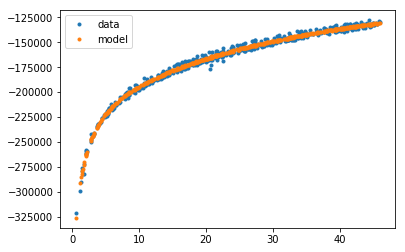

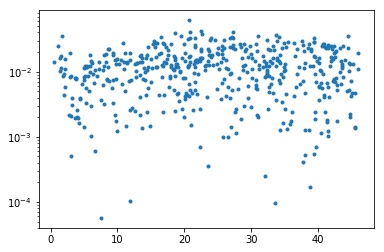

snapnr: 116
22:17:09.879828
[ 30.11922264  29.0051918   32.35468674]
calculate galpy potentials


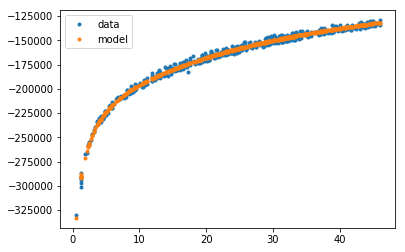

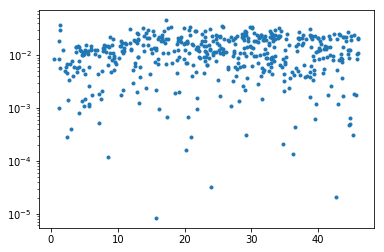

snapnr: 117
22:17:30.729574
[ 30.55345726  29.42549706  32.85093689]
calculate galpy potentials


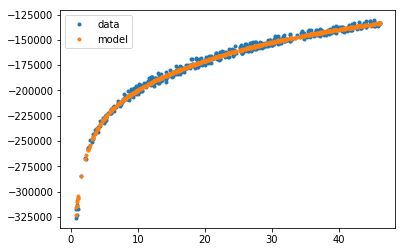

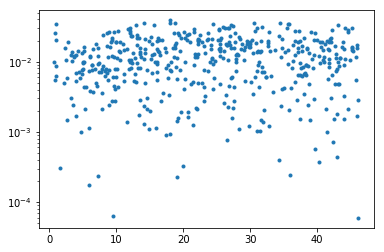

snapnr: 118
22:17:53.420352
[ 30.99422073  29.85132217  33.35467911]
calculate galpy potentials


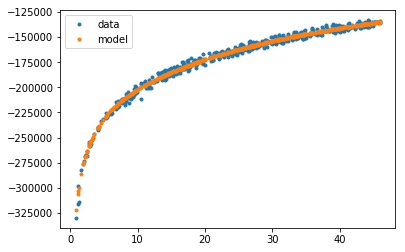

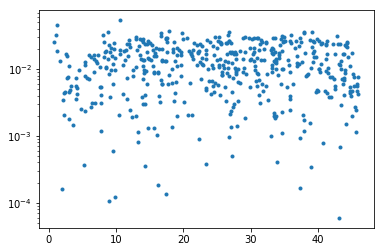

snapnr: 119
22:18:14.454290
[ 31.29102707  30.13891983  33.69516754]
calculate galpy potentials


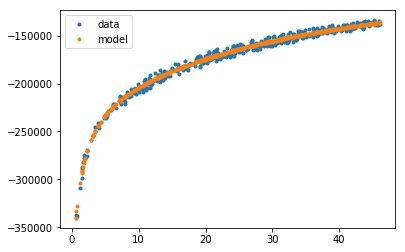

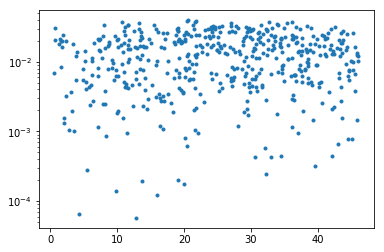

snapnr: 120
22:18:35.749637
[ 31.74212646  30.57429314  34.21273041]
calculate galpy potentials


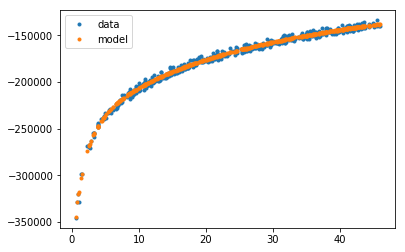

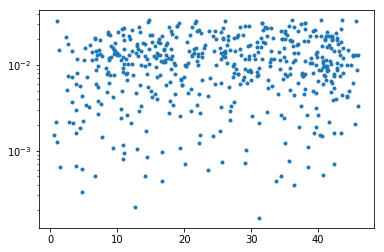

snapnr: 121
22:18:56.641956
[ 32.04627228  30.8679924   34.56239319]
calculate galpy potentials


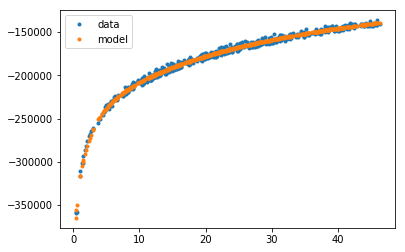

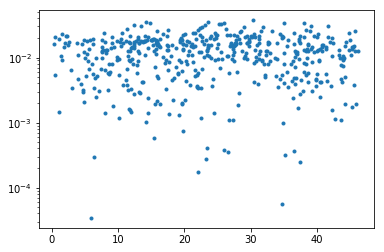

snapnr: 122
22:19:18.032176
[ 32.50867844  31.31370544  35.09283066]
calculate galpy potentials


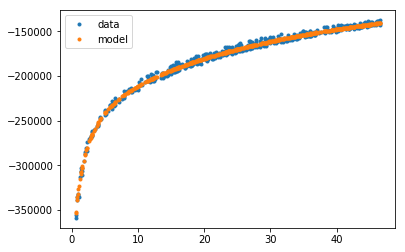

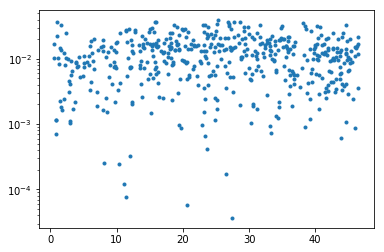

snapnr: 123
22:19:39.931630
[ 32.82047653  31.61475182  35.45058823]
calculate galpy potentials


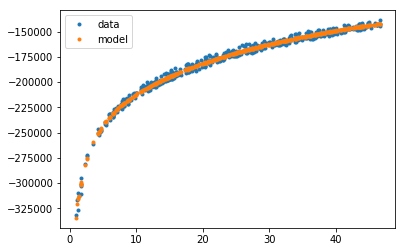

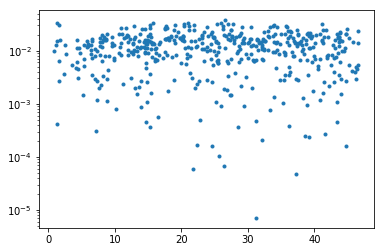

snapnr: 124
22:20:01.998746
[ 33.29346848  32.07149124  35.99433899]
calculate galpy potentials


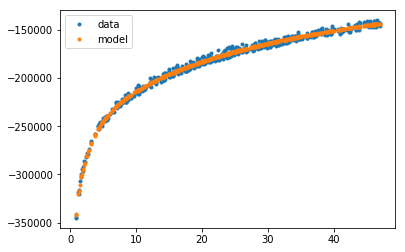

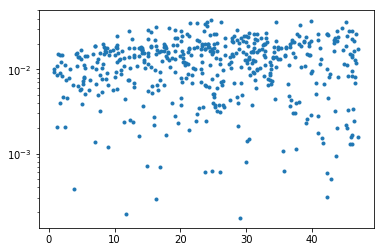

snapnr: 125
22:20:22.930794
[ 33.61259842  32.37949753  36.36141205]
calculate galpy potentials


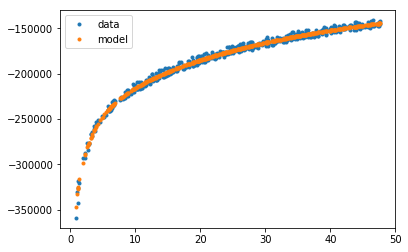

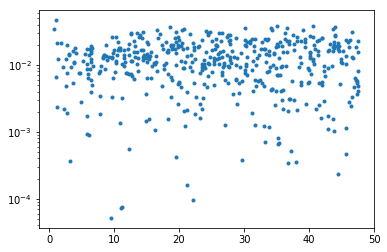

snapnr: 126
22:20:44.955475
[ 34.09642792  32.84707642  36.91917419]
calculate galpy potentials


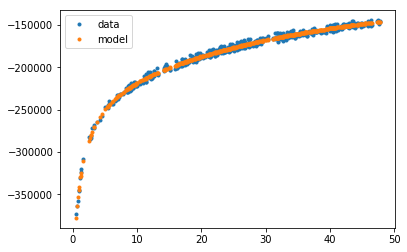

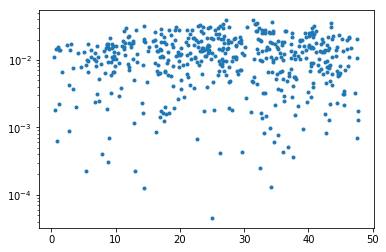

snapnr: 127
22:21:06.079594
[ 34.42281723  33.16259384  37.29567337]
calculate galpy potentials


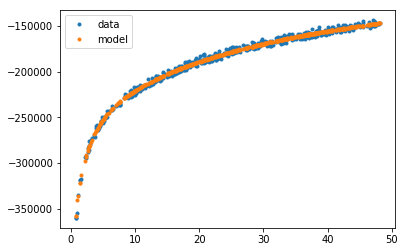

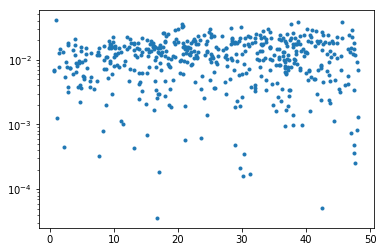

In [8]:
# check if potential values agree

level = 4
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"

_REFR0_kpc =8.

for i_snap, snap in enumerate(snapnr):
    if snap < 75:
        continue

    pot = setup_galpy_potential(a_MND_kpc[i_snap], b_MND_kpc[i_snap], a_NFWH_kpc[i_snap], a_HB_kpc[i_snap], n_MND[i_snap], n_NFWH[i_snap], n_HB[i_snap]) 
    _REFV0_kms = v0_kms[i_snap]
    
    print("snapnr: {0}".format(snap))
    print(datetime.datetime.now().time())
    try:
        s1, sf1 = eat_snap_and_fof(level, halo_number, snap, snappath, loadonlytype=[1,2,3,4], 
        haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
    except KeyError:
        print('\n\n', snapnr, 'not read in.\n\n')
        continue
    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    #s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 ) 
    
    mask = np.where((s1.halo == 0) & (s1.r() < 2. * s1.galrad) & (s1.r() > 0.) & ((s1.type == 1) + (s1.type == 2) + (s1.type == 3)) )
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s1, sf1, mask)
    r_kpc = np.sqrt(R_kpc**2 + z_kpc **2)
    pot_kms2_data = s1.pot[mask]
    print('calculate galpy potentials')
    pot_kms2_model = evaluatePotentials(pot,
                                   R_kpc / _REFR0_kpc,
                                   z_kpc / _REFR0_kpc) * _REFV0_kms**2
    
    '''    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    x, y, z = R_kpc_binned, z_kpc_binned, rho
    im1 = ax1.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.2)
    cbar1 = fig.colorbar(im1, cax=cax1)
    
    x, y, z = R_kpc_binned, z_kpc_binned, densities

    im2 = ax2.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.2)
    cbar2 = fig.colorbar(im2, cax=cax2)
    
    x, y, z = R_kpc_binned, z_kpc_binned, (densities-rho)
    im3 = ax3.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.2)
    cbar3 = fig.colorbar(im3, cax=cax3)
    display(fig)
    '''
    samp = random.sample(range(len(r_kpc)), 500)
    plt.plot(r_kpc[samp], pot_kms2_data[samp], '.', label = 'data')
    plt.plot(r_kpc[samp], pot_kms2_model[samp], '.', label = 'model')
    #plt.plot(r_kpc[samp], pot_kms2_data[samp] - pot_kms2_model[samp], '.', label = 'abs diff')
    plt.legend()
    plt.show()
    plt.semilogy(r_kpc[samp], np.abs(pot_kms2_data[samp] - pot_kms2_model[samp])/np.abs(pot_kms2_data[samp]), '.')
    plt.show()

snapnr: 75
09:30:41.767090
[ 16.16160011  15.58262157  16.72860718]
09:31:01.842646
start data density calculation
09:31:07.028807
start fitted density calculation


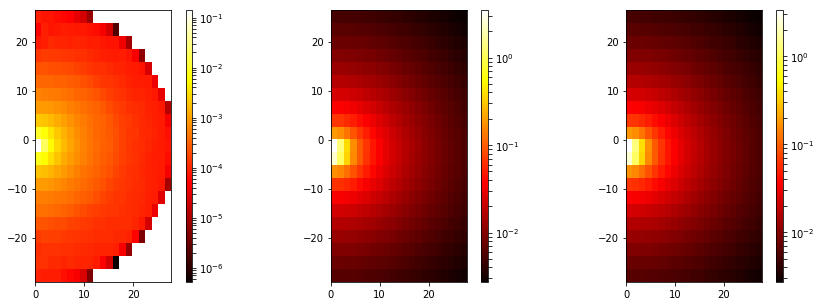

snapnr: 76
09:31:08.071751
[ 16.47659492  15.88422775  17.06827354]
09:31:28.634760
start data density calculation
09:31:34.051186
start fitted density calculation


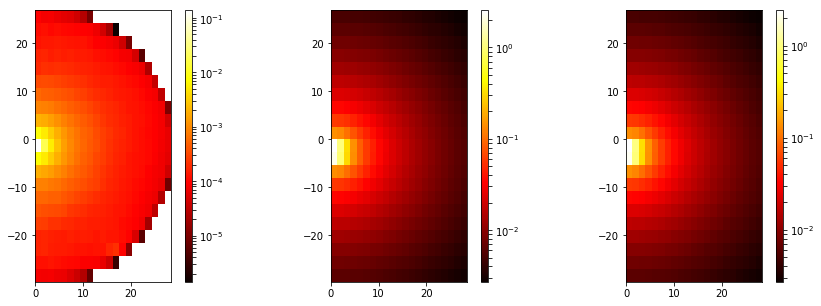

snapnr: 77
09:31:35.064146
[ 16.79800034  16.19346237  17.41295624]
09:31:54.750507
start data density calculation
09:31:59.163815
start fitted density calculation


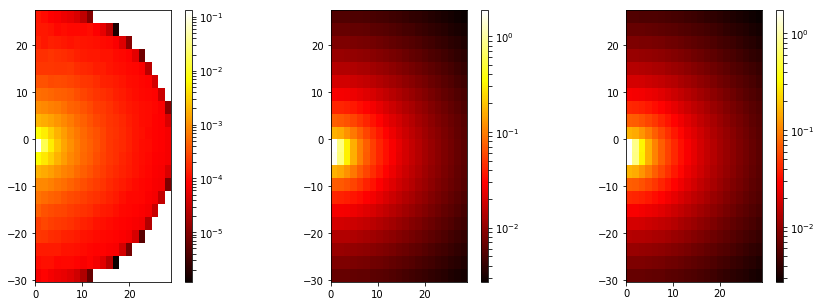

snapnr: 78
09:32:00.450369
[ 17.20534706  16.5902729   17.85304451]
09:32:17.746451
start data density calculation
09:32:22.334836
start fitted density calculation


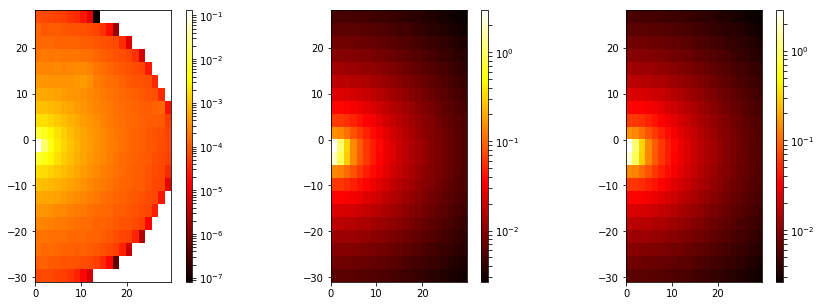

snapnr: 79
09:32:23.421492
[ 17.53638649  16.91461563  18.2147541 ]
09:32:42.428587
start data density calculation
09:32:47.196803
start fitted density calculation


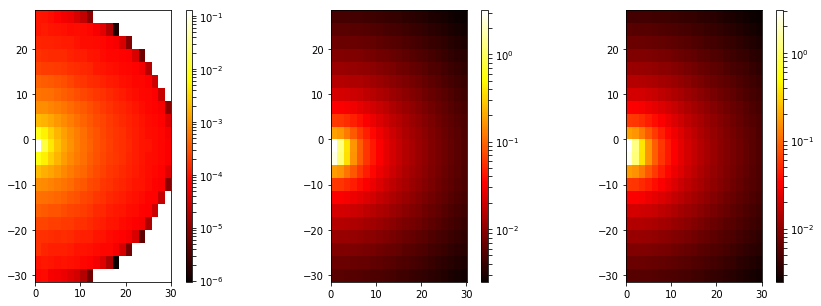

snapnr: 80
09:32:48.237977
[ 17.78905106  17.16118431  18.49117279]
09:33:05.602856
start data density calculation
09:33:11.307136
start fitted density calculation


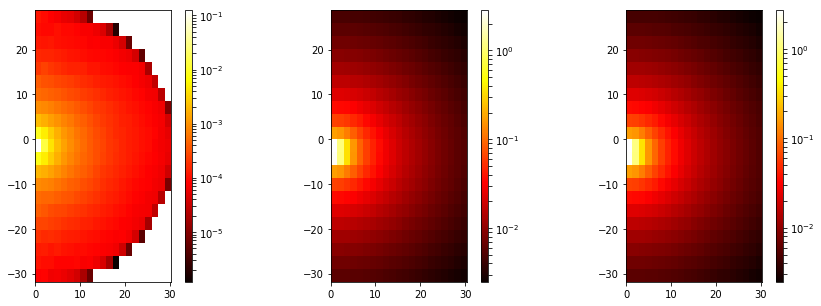

snapnr: 81
09:33:12.620561
[ 18.13132668  17.49447441  18.86812019]
09:33:29.247791
start data density calculation
09:33:34.485040
start fitted density calculation


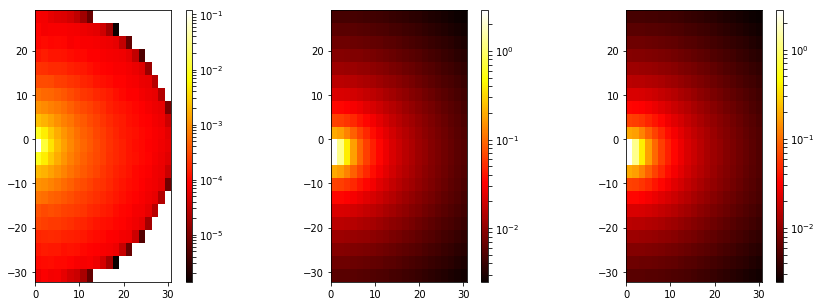

snapnr: 82
09:33:35.496285
[ 18.48038101  17.83345413  19.25479507]
09:33:54.160954
start data density calculation
09:34:00.149294
start fitted density calculation


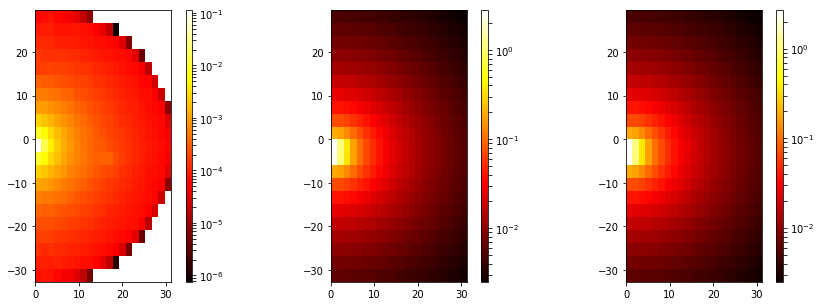

snapnr: 83
09:34:01.204661
[ 18.83633041  18.17889214  19.65101624]
09:34:19.585919
start data density calculation
09:34:26.050971
start fitted density calculation


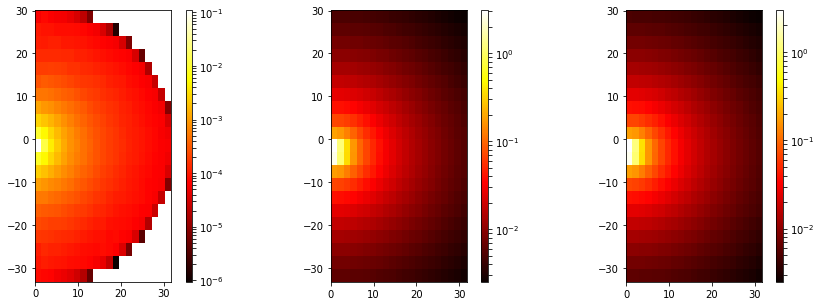

snapnr: 84
09:34:27.469085
[ 19.10744095  18.44243622  19.95356178]
09:34:47.225894
start data density calculation
09:34:53.994010
start fitted density calculation


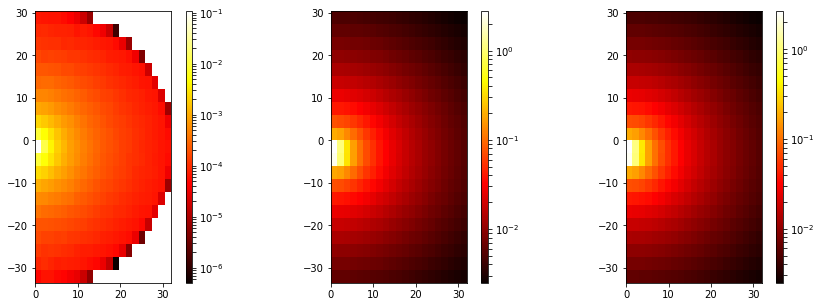

snapnr: 85
09:34:55.080204
[ 19.47507477  18.79951668  20.36402512]
09:35:12.897056
start data density calculation
09:35:19.715043
start fitted density calculation


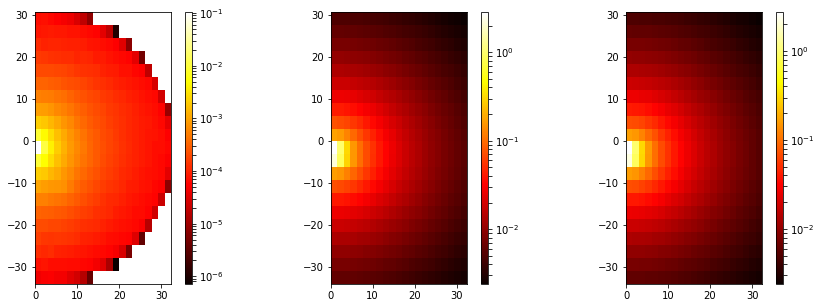

snapnr: 86
09:35:20.786468
[ 19.75509262  19.0717144   20.67724609]
09:35:38.505331
start data density calculation
09:35:45.579522
start fitted density calculation


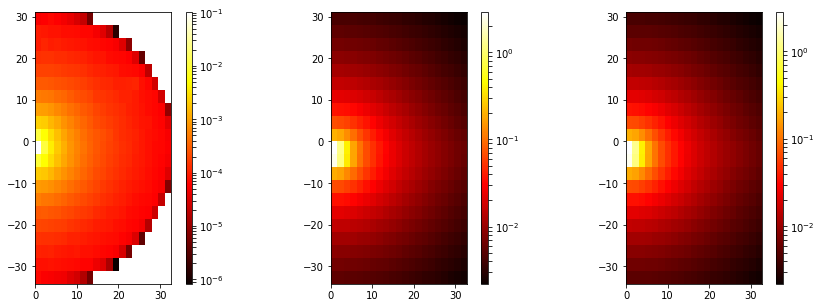

snapnr: 87
09:35:46.640935
[ 20.13412285  19.44070625  21.10229874]
09:36:02.798608
start data density calculation
09:36:09.416673
start fitted density calculation


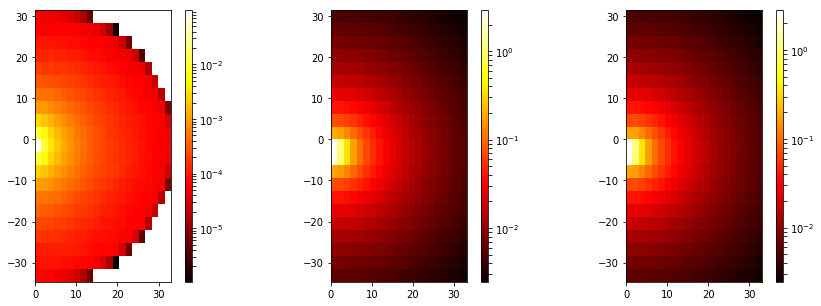

snapnr: 88
09:36:10.440832
[ 20.42412758  19.72184372  21.42675972]
09:36:26.969916
start data density calculation
09:36:33.304033
start fitted density calculation


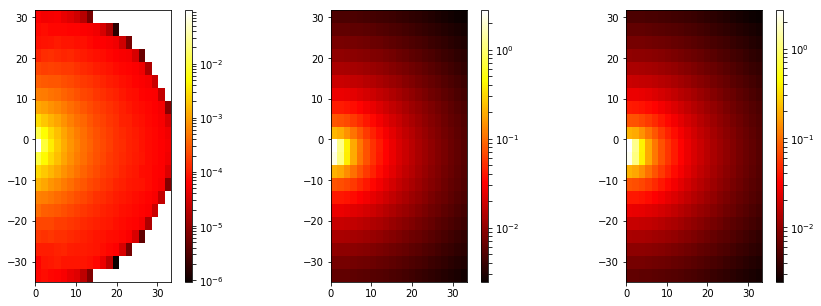

snapnr: 89
09:36:34.845400
[ 20.81840324  20.10211563  21.86827469]
09:36:53.165451
start data density calculation
09:37:00.002450
start fitted density calculation


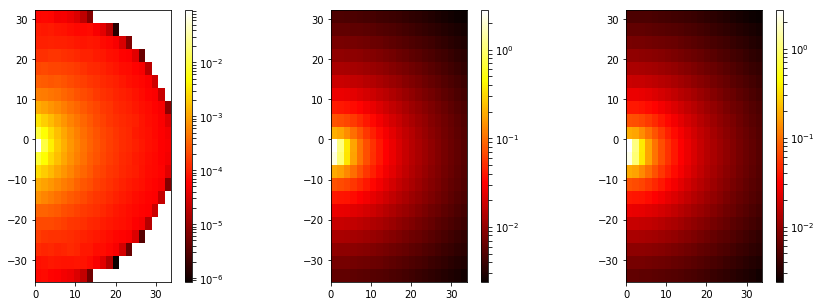

snapnr: 90
09:37:01.091108
[ 21.11937714  20.39230919  22.20462799]
09:37:18.075670
start data density calculation
09:37:24.767064
start fitted density calculation


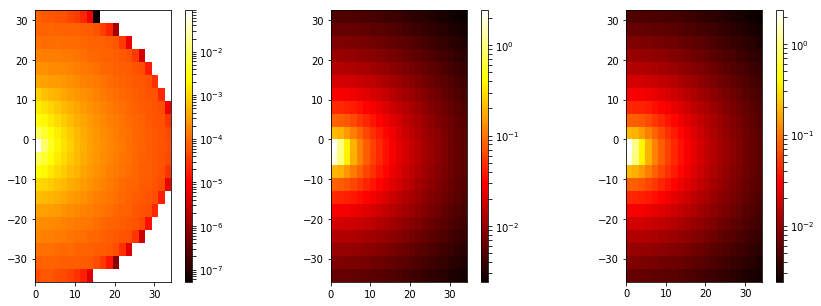

snapnr: 91
09:37:25.880728
[ 21.42389488  20.68611908  22.54693604]
09:37:44.756949
start data density calculation
09:37:51.798536
start fitted density calculation


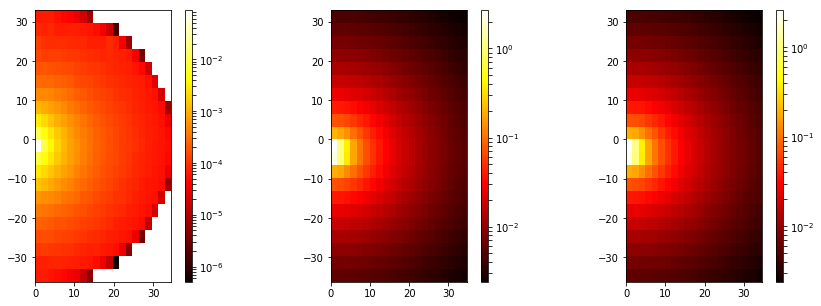

snapnr: 92
09:37:52.871376
[ 21.73373222  20.98360252  22.89403915]
09:38:11.739855
start data density calculation
09:38:18.881097
start fitted density calculation


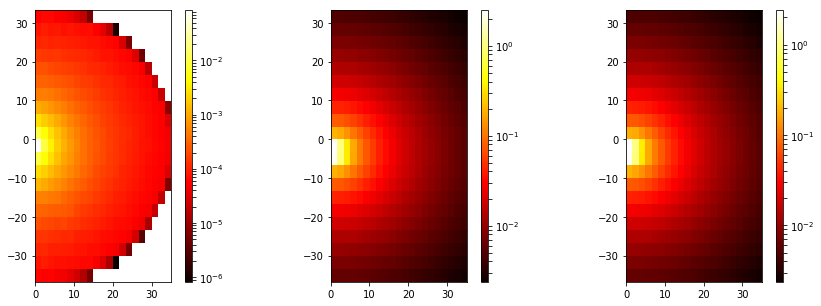

snapnr: 93
09:38:19.940718
[ 22.153759    21.38641167  23.364851  ]
09:38:38.179549
start data density calculation
09:38:46.209478
start fitted density calculation


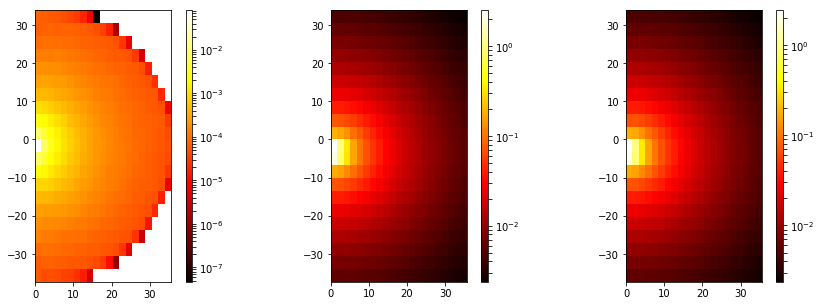

snapnr: 94
09:38:47.826345
[ 22.47373009  21.69274902  23.72468185]
09:39:07.324685
start data density calculation
09:39:15.123222
start fitted density calculation


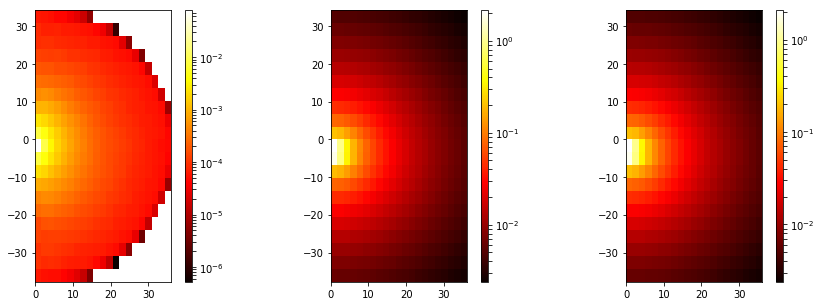

snapnr: 95
09:39:16.209817
[ 22.7996521   22.0025444   24.08984756]
09:39:36.050993
start data density calculation
09:39:45.882438
start fitted density calculation
/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



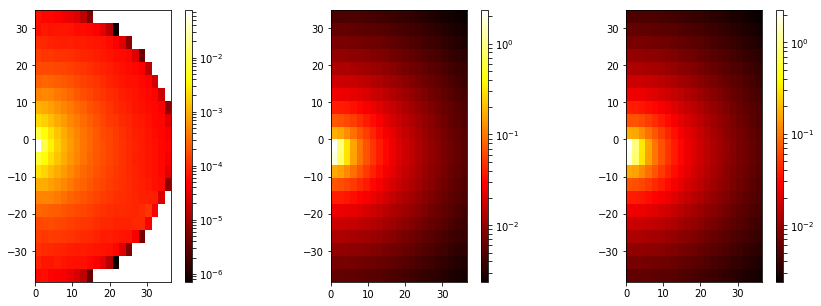

snapnr: 96
09:39:46.940898
[ 23.13161278  22.31706619  24.45867538]
09:40:05.426519
start data density calculation
09:40:14.633449
start fitted density calculation


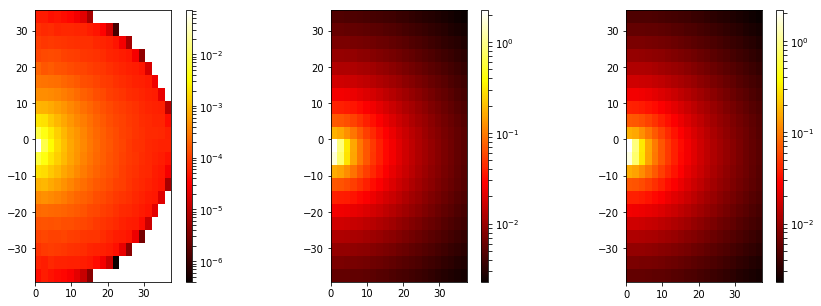

snapnr: 97
09:40:15.702361
[ 23.46821594  22.63773918  24.8325634 ]
09:40:34.322726
start data density calculation
09:40:42.436979
start fitted density calculation


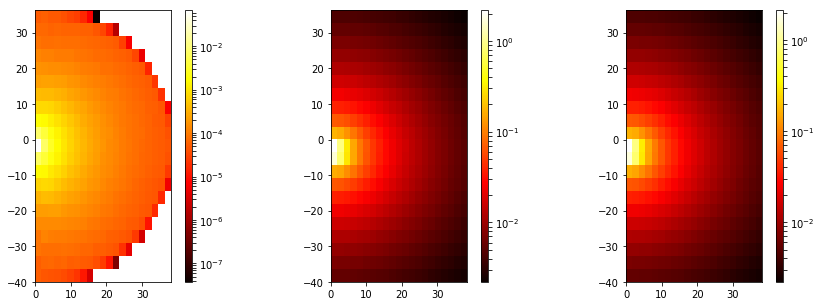

snapnr: 98
09:40:43.546953
[ 23.80860329  22.96368408  25.21352386]
09:41:01.139720
start data density calculation
09:41:09.136165
start fitted density calculation


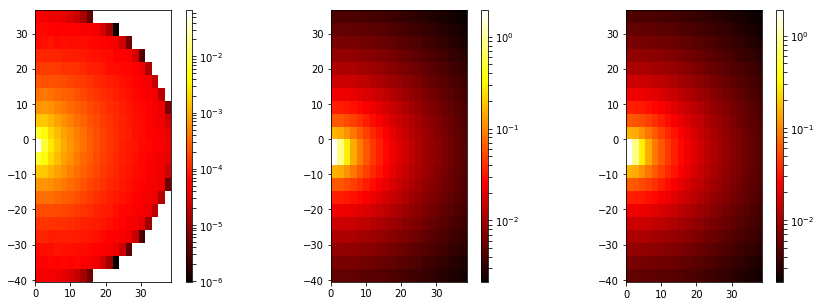

snapnr: 99
09:41:10.769892
[ 24.15342522  23.29395103  25.60112953]
09:41:30.165677
start data density calculation
09:41:38.445192
start fitted density calculation


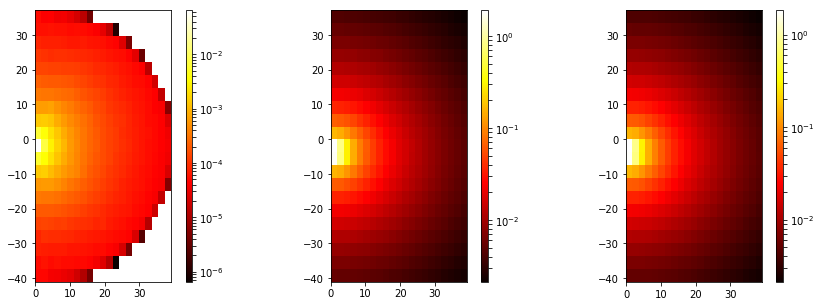

snapnr: 100
09:41:39.513189
[ 24.50271797  23.62892342  25.99520683]
09:41:57.759554
start data density calculation
09:42:07.210238
start fitted density calculation


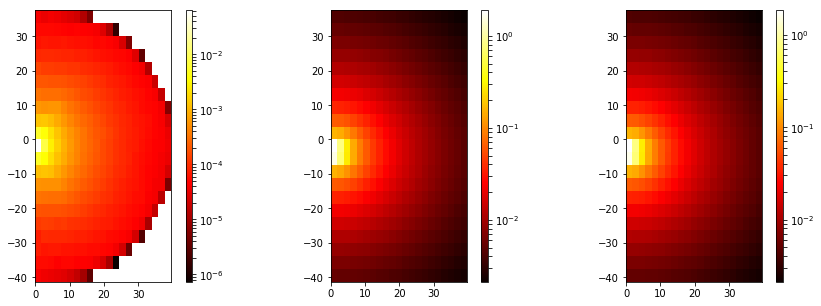

snapnr: 101
09:42:08.282224
[ 24.85713387  23.96839905  26.39595032]
09:42:28.751215
start data density calculation
09:42:38.201221
start fitted density calculation


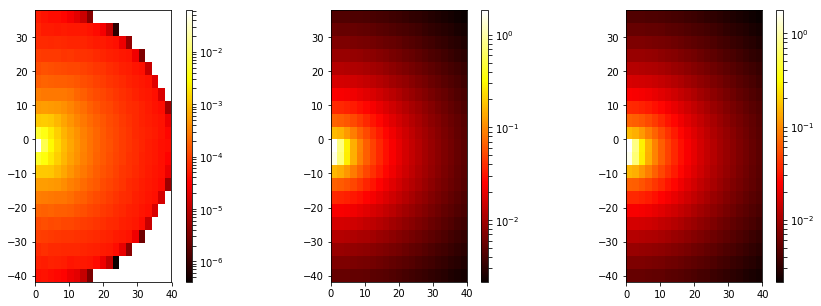

snapnr: 102
09:42:39.572113
[ 25.21674347  24.31293106  26.80324364]
09:42:58.119981
start data density calculation
09:43:06.532129
start fitted density calculation


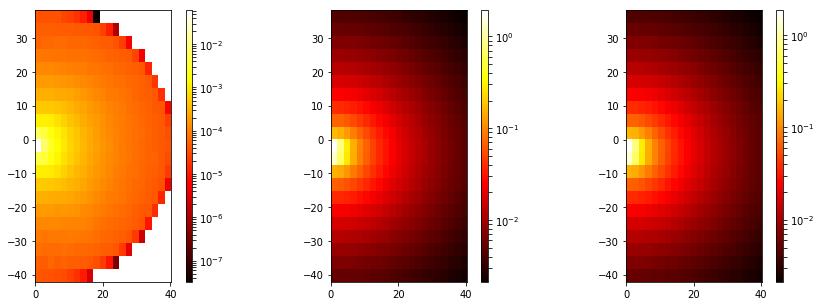

snapnr: 103
09:43:07.639539
[ 25.45941925  24.54529381  27.07883453]
09:43:27.572152
start data density calculation
09:43:36.227525
start fitted density calculation


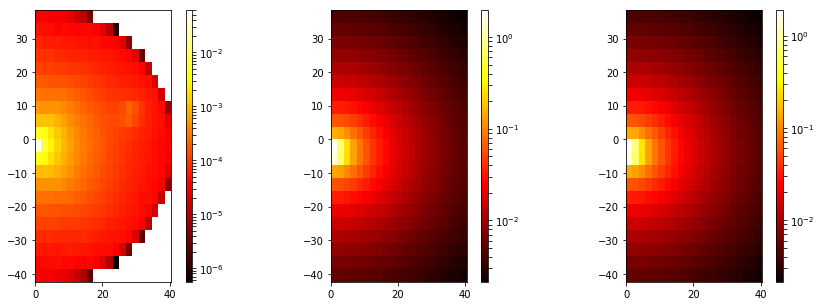

snapnr: 104
09:43:37.298847
[ 25.82858849  24.89687347  27.49774933]
09:43:55.699050
start data density calculation
09:44:04.926293
start fitted density calculation


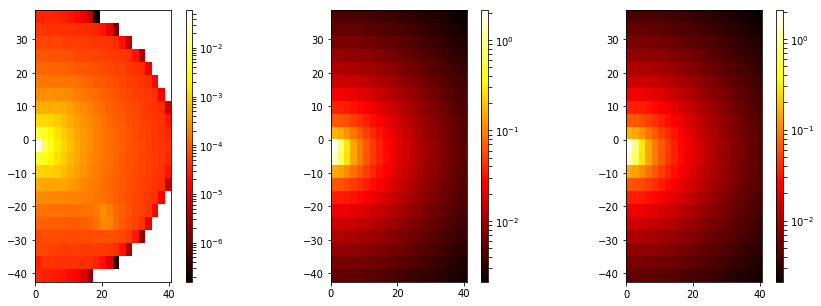

snapnr: 105
09:44:05.994404
[ 26.2042942   25.2542057   27.92131042]
09:44:25.732947
start data density calculation
09:44:34.983306
start fitted density calculation


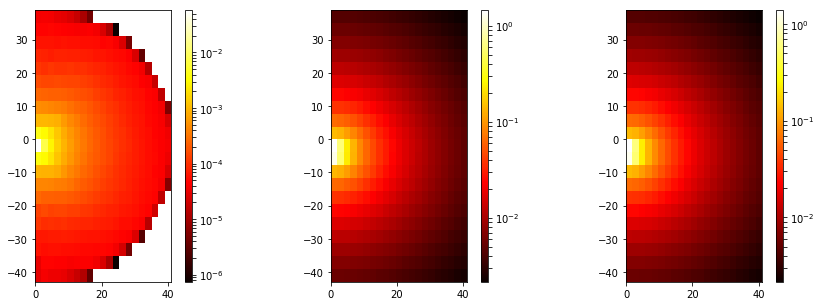

snapnr: 106
09:44:36.796002
[ 26.58517647  25.61821175  28.35095024]
09:44:57.327864
start data density calculation
09:45:06.283506
start fitted density calculation


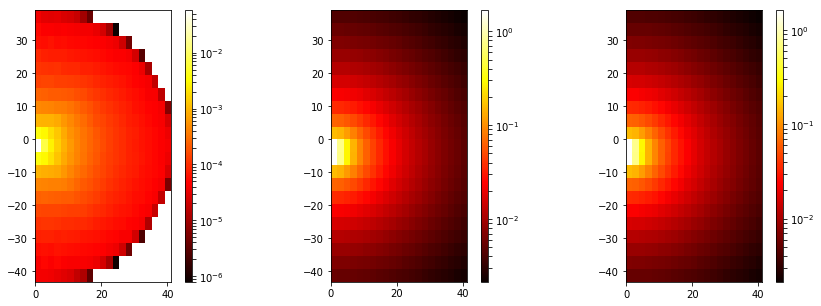

snapnr: 107
09:45:07.344190
[ 26.97145081  25.98770905  28.78736305]
09:45:27.976518
start data density calculation
09:45:38.737765
start fitted density calculation


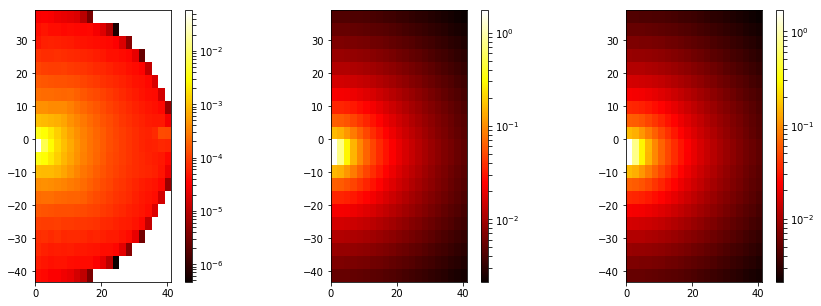

snapnr: 108
09:45:39.799669
[ 27.23214722  26.23708725  29.08192825]
09:46:00.775733
start data density calculation
09:46:10.786167
start fitted density calculation


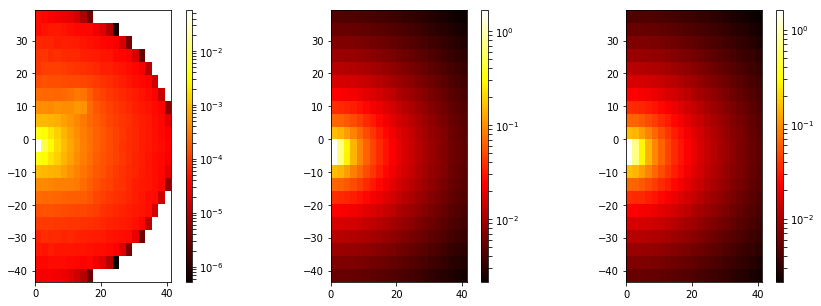

snapnr: 109
09:46:11.844067
[ 27.62681198  26.61546135  29.52968025]
09:46:32.570940
start data density calculation
09:46:43.208931
start fitted density calculation


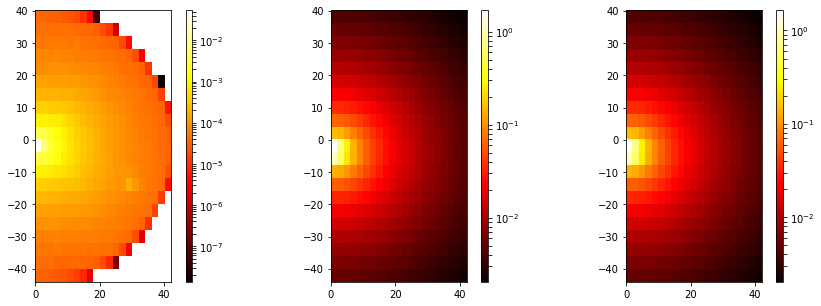

snapnr: 110
09:46:44.338753
[ 28.02821541  26.99830246  29.98339081]
09:47:03.683171
start data density calculation
09:47:13.253523
start fitted density calculation


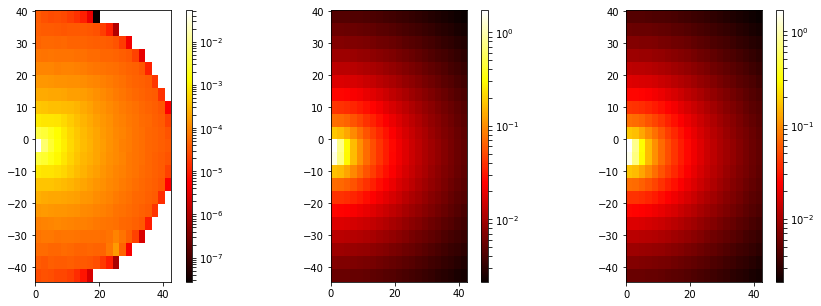

snapnr: 111
09:47:14.424531
[ 28.29884148  27.25717163  30.28975487]
09:47:34.330480
start data density calculation
09:47:44.713493
start fitted density calculation


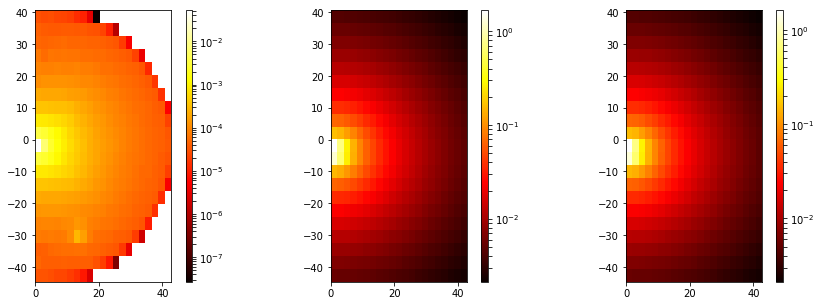

snapnr: 112
09:47:45.842551
[ 28.71037102  27.65019417  30.75450516]
09:48:04.387533
start data density calculation
09:48:13.838043
start fitted density calculation


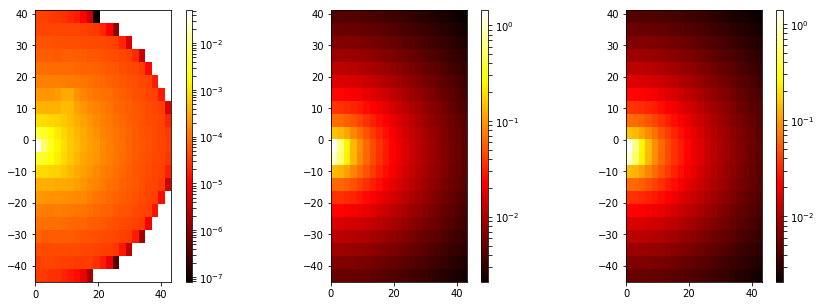

snapnr: 113
09:48:14.994423
[ 29.12677383  28.04948807  31.22624779]
09:48:33.659653
start data density calculation
09:48:43.397531
start fitted density calculation


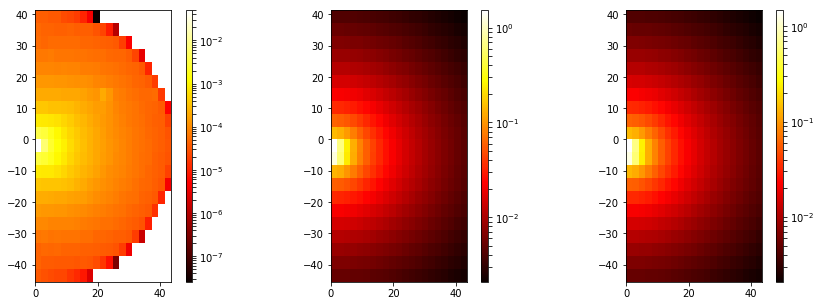

snapnr: 114
09:48:45.360188
[ 29.40730476  28.31895065  31.54471207]
09:49:06.168627
start data density calculation
09:49:17.268657
start fitted density calculation


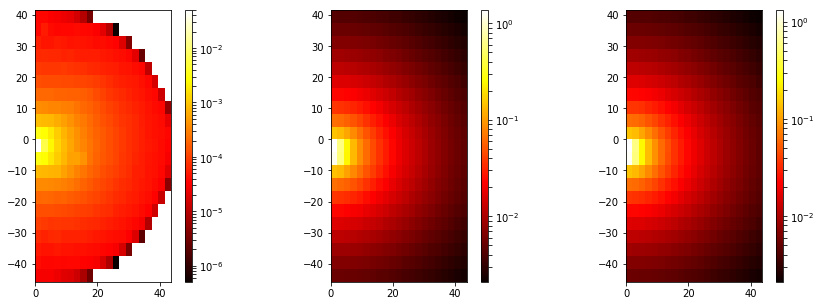

snapnr: 115
09:49:18.343758
[ 29.83269691  28.72842789  32.02832794]
09:49:37.676908
start data density calculation
09:49:46.149503
start fitted density calculation


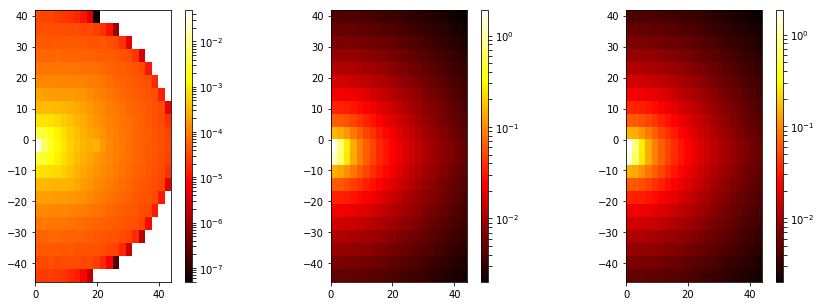

snapnr: 116
09:49:47.262433
[ 30.11922264  29.0051918   32.35468674]
09:50:06.590982
start data density calculation
09:50:15.938365
start fitted density calculation


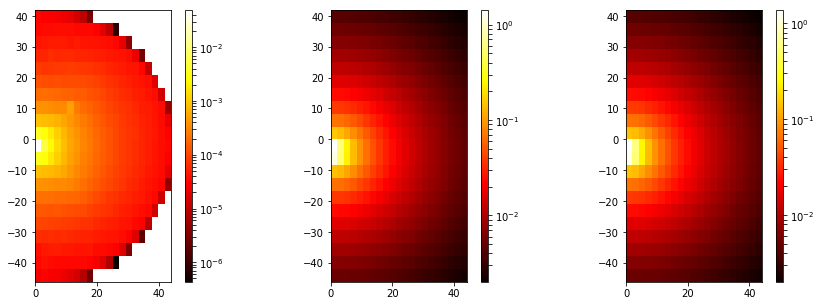

snapnr: 117
09:50:16.996527
[ 30.55345726  29.42549706  32.85093689]
09:50:36.574954
start data density calculation
09:50:45.046304
start fitted density calculation


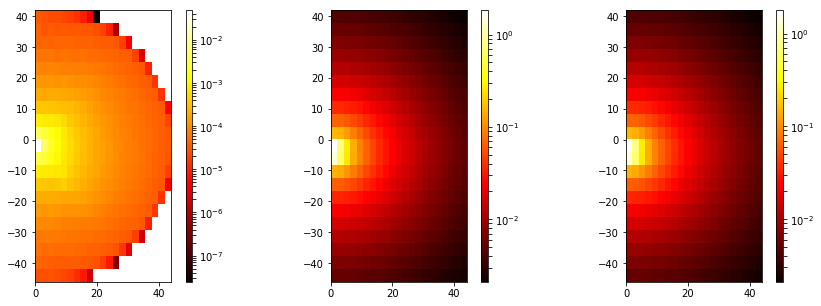

snapnr: 118
09:50:46.170401
[ 30.99422073  29.85132217  33.35467911]
09:51:06.307213
start data density calculation
09:51:17.895806
start fitted density calculation


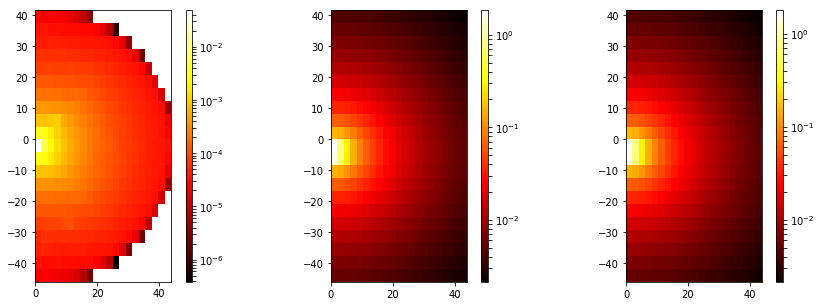

snapnr: 119
09:51:18.972694
[ 31.29102707  30.13891983  33.69516754]
09:51:40.009712
start data density calculation
09:51:48.775810
start fitted density calculation


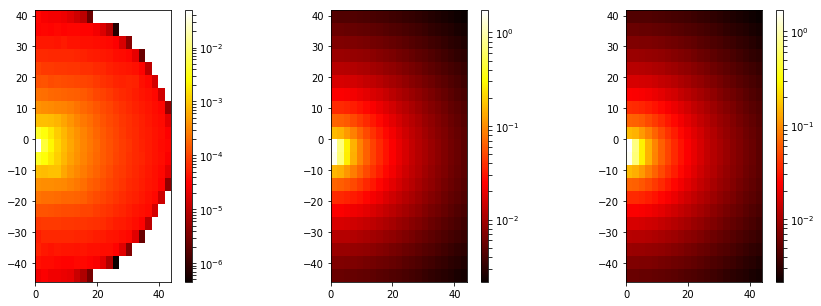

snapnr: 120
09:51:49.833634
[ 31.74212646  30.57429314  34.21273041]
09:52:09.217200
start data density calculation
09:52:18.675614
start fitted density calculation


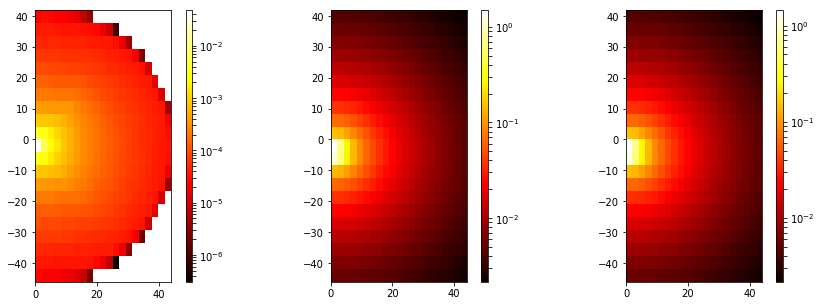

snapnr: 121
09:52:19.739499
[ 32.04627228  30.8679924   34.56239319]
09:52:39.256731
start data density calculation
09:52:48.341363
start fitted density calculation


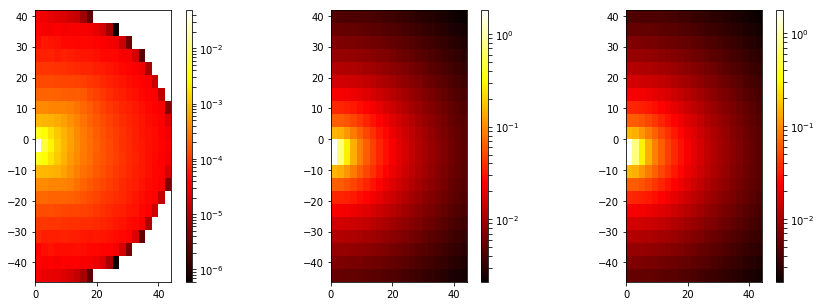

snapnr: 122
09:52:49.398653
[ 32.50867844  31.31370544  35.09283066]
09:53:09.659538
start data density calculation
09:53:19.297012
start fitted density calculation


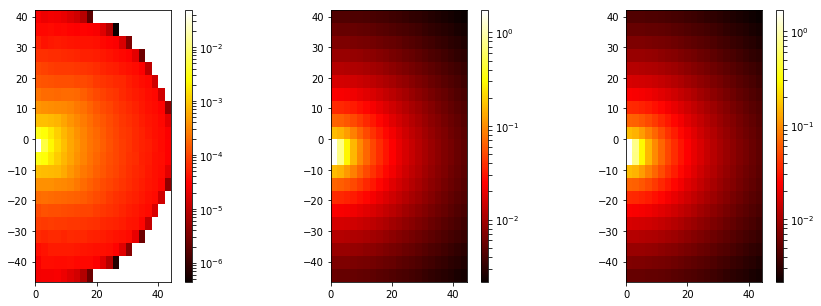

snapnr: 123
09:53:21.495689
[ 32.82047653  31.61475182  35.45058823]
09:53:41.392060
start data density calculation
09:53:52.092069
start fitted density calculation


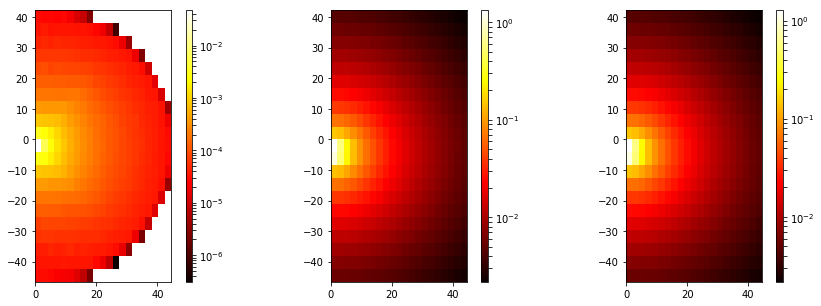

snapnr: 124
09:53:53.170619
[ 33.29346848  32.07149124  35.99433899]
09:54:14.574167
start data density calculation
09:54:27.466280
start fitted density calculation


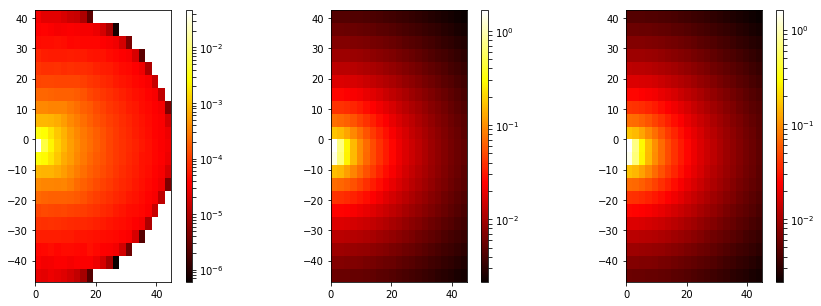

snapnr: 125
09:54:28.580027
[ 33.61259842  32.37949753  36.36141205]
09:54:49.202180
start data density calculation
09:55:00.376910
start fitted density calculation


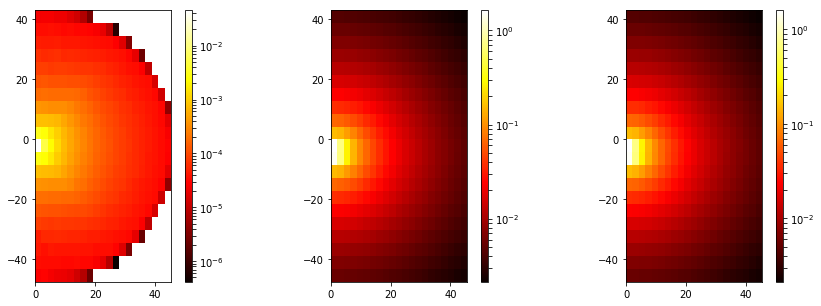

snapnr: 126
09:55:01.425969
[ 34.09642792  32.84707642  36.91917419]
09:55:22.829878
start data density calculation
09:55:34.295212
start fitted density calculation


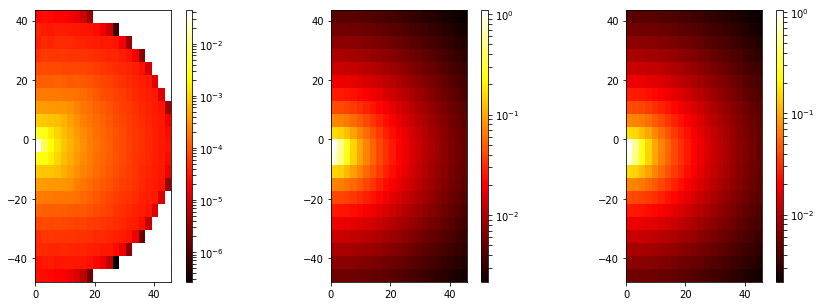

snapnr: 127
09:55:35.326723
[ 34.42281723  33.16259384  37.29567337]
09:55:55.374532
start data density calculation
09:56:08.713659
start fitted density calculation


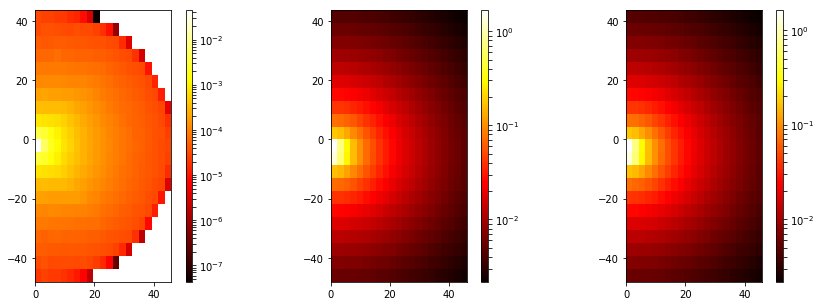

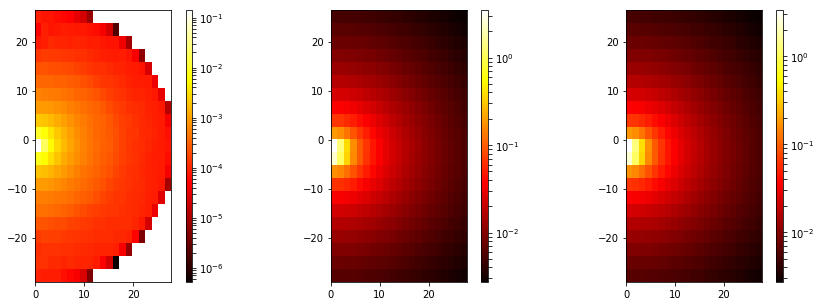

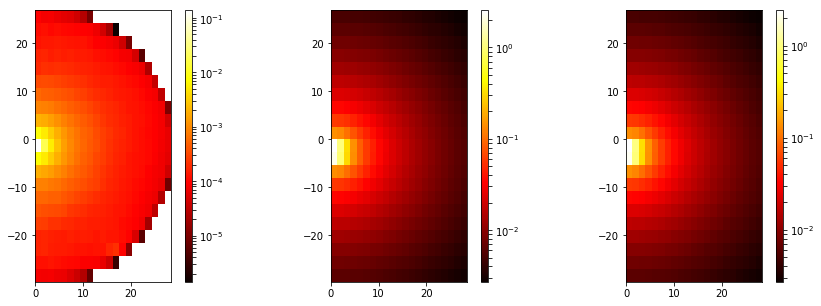

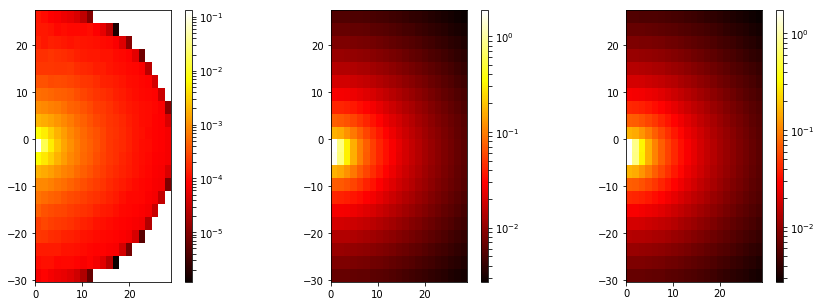

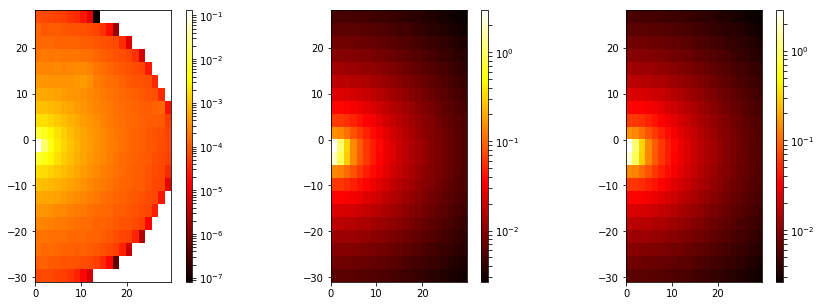

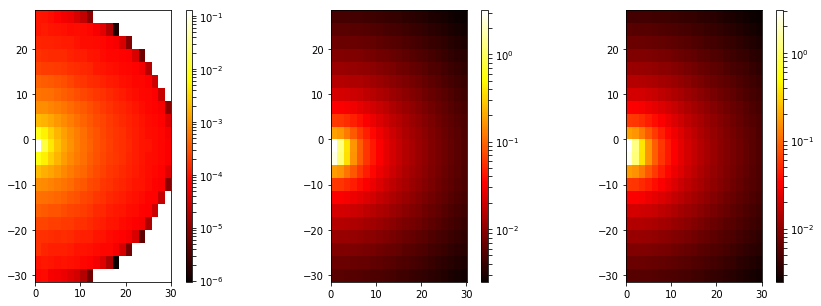

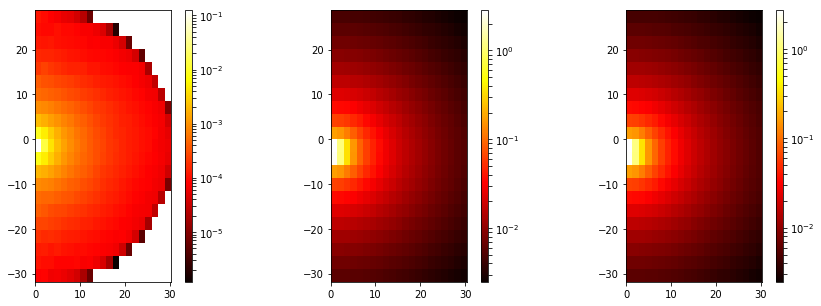

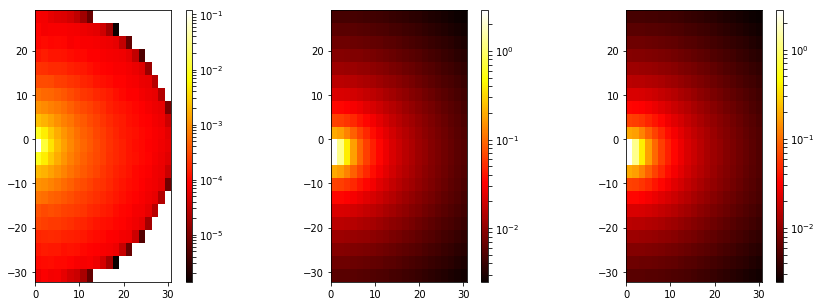

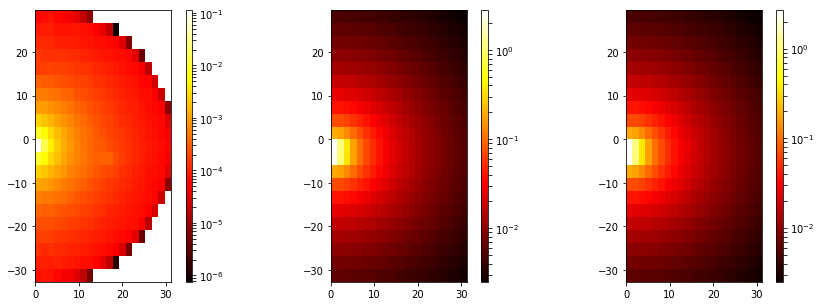

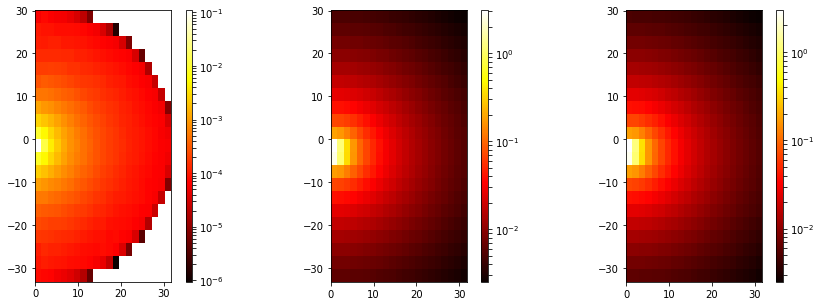

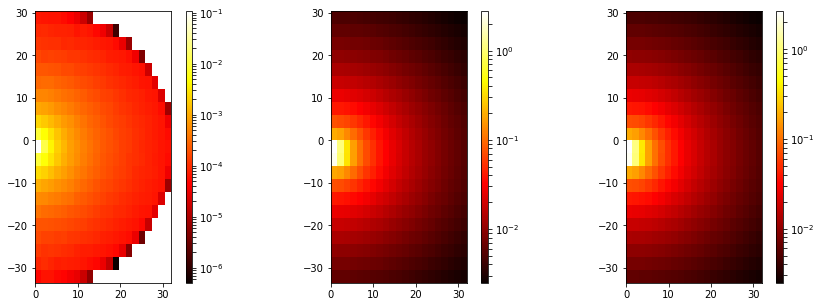

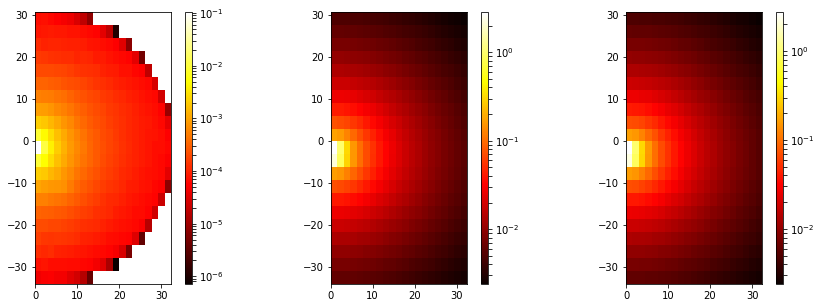

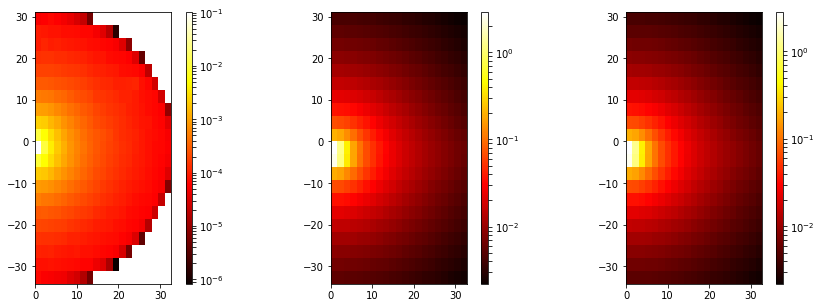

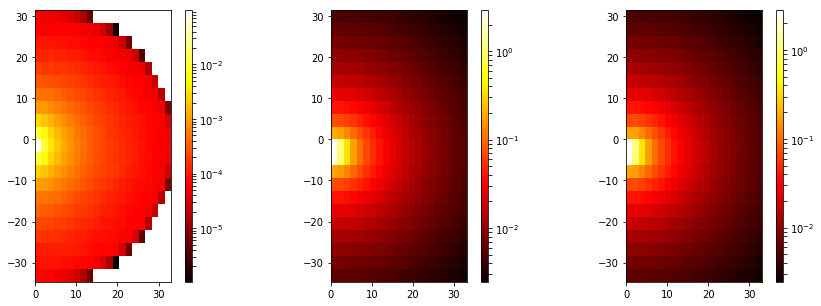

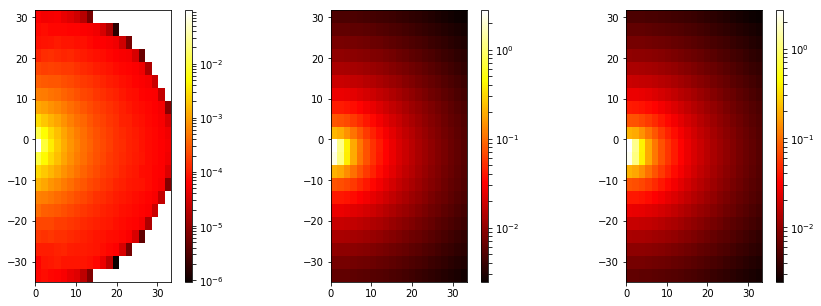

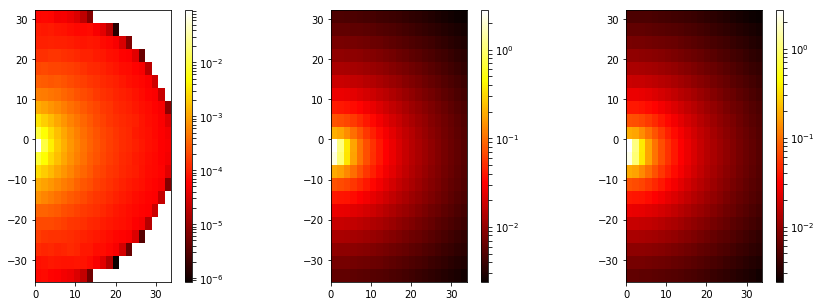

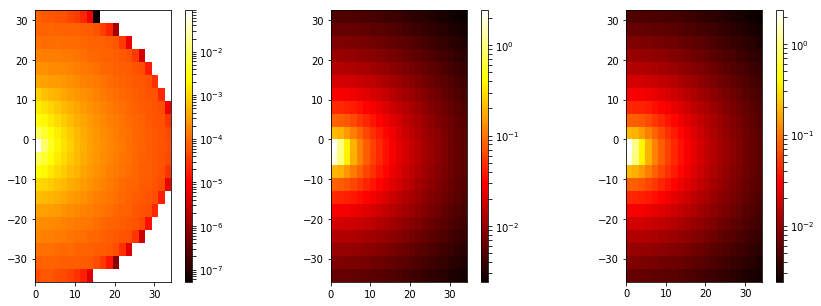

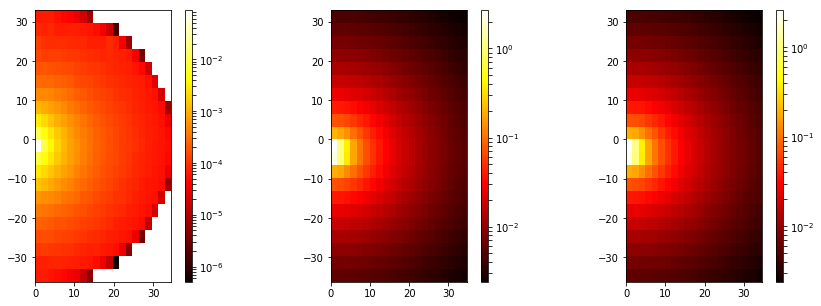

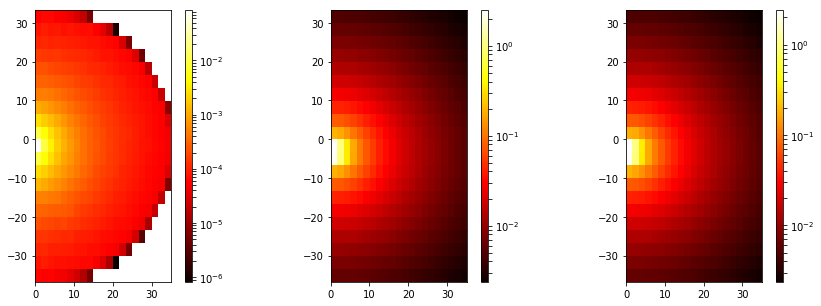

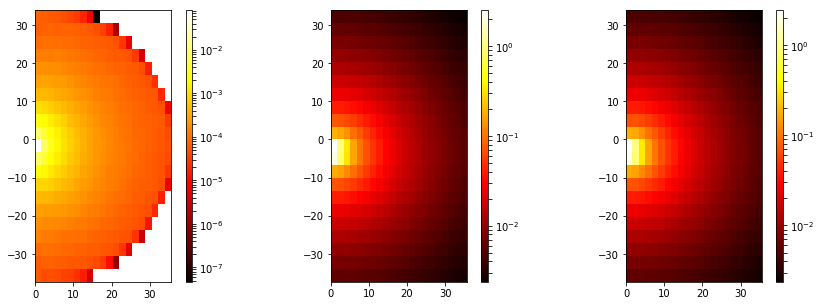

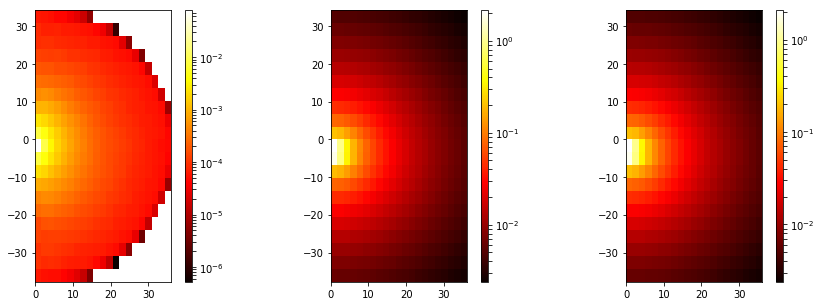

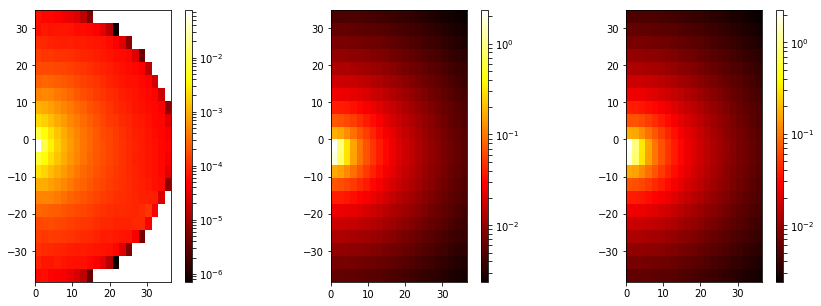

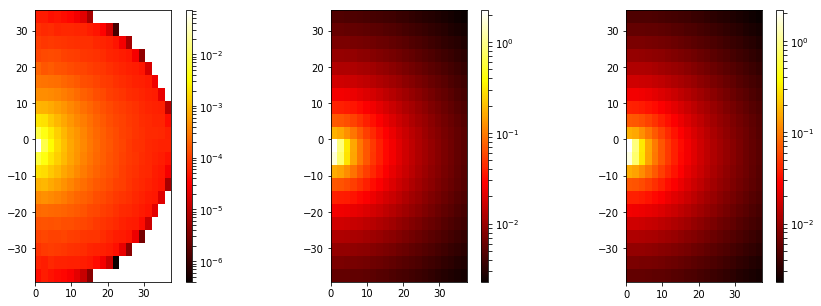

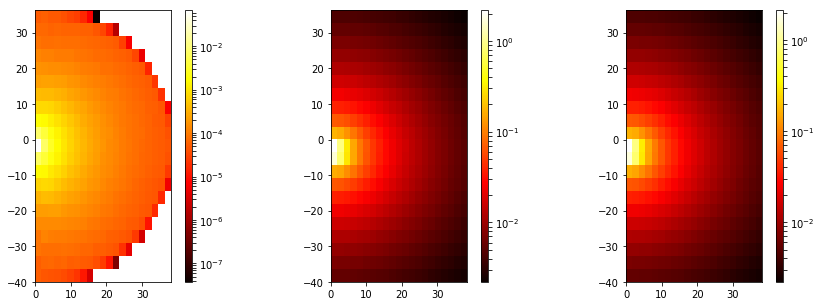

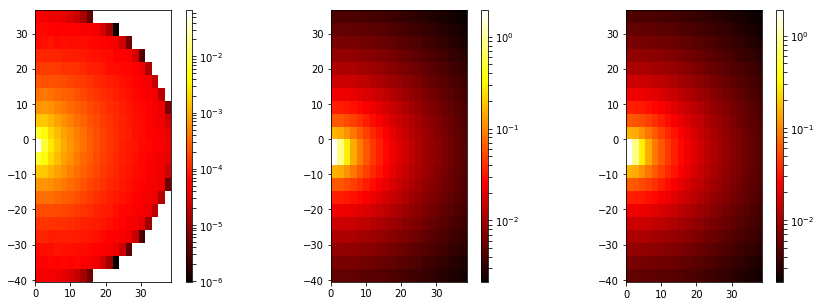

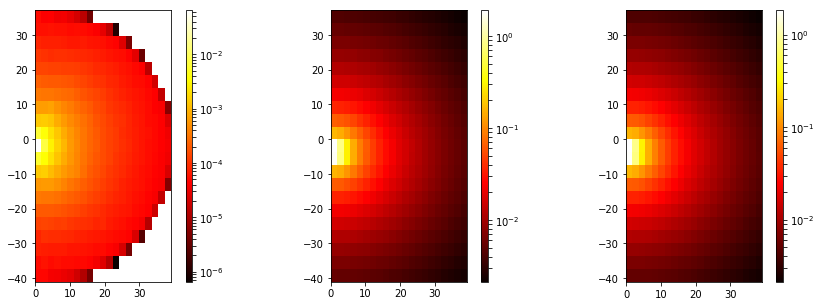

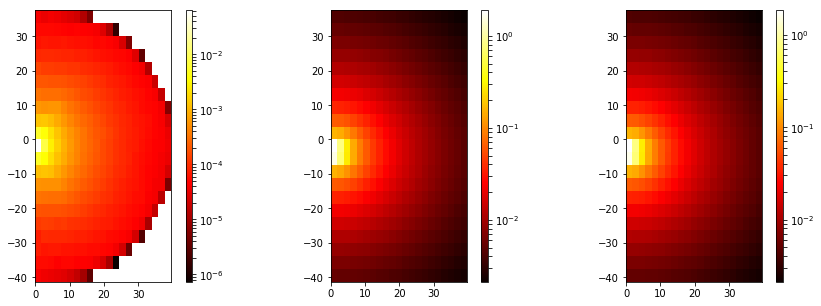

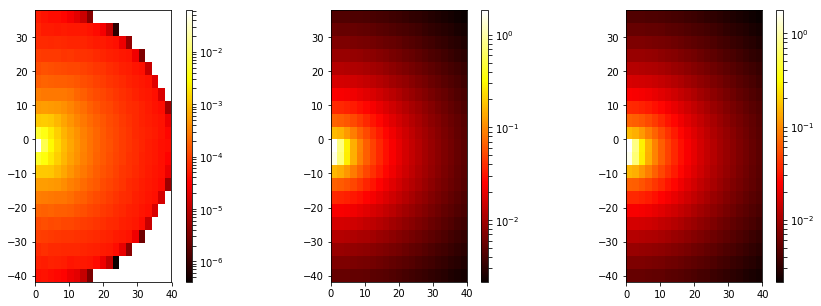

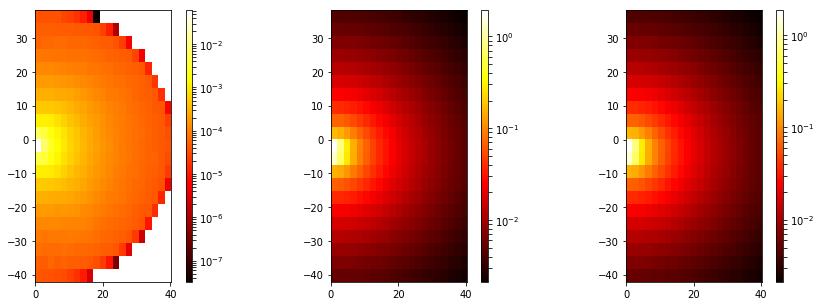

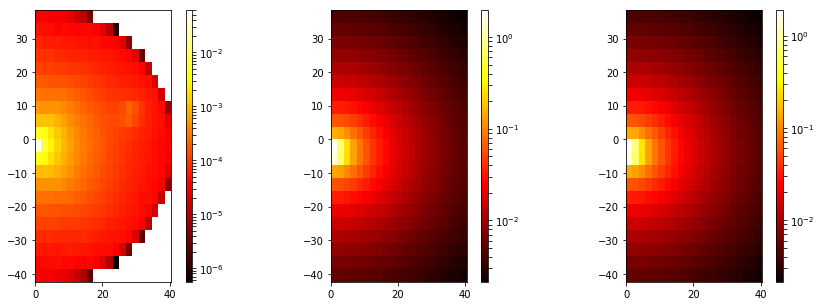

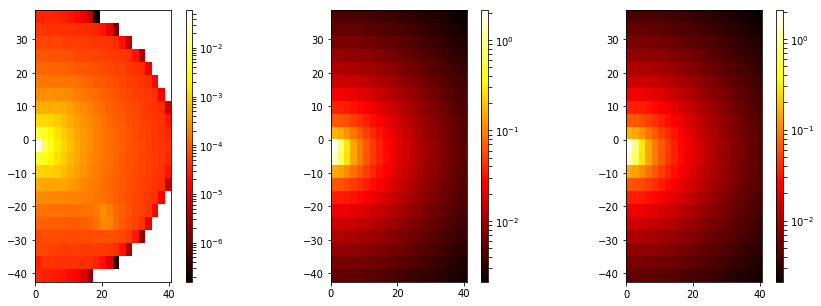

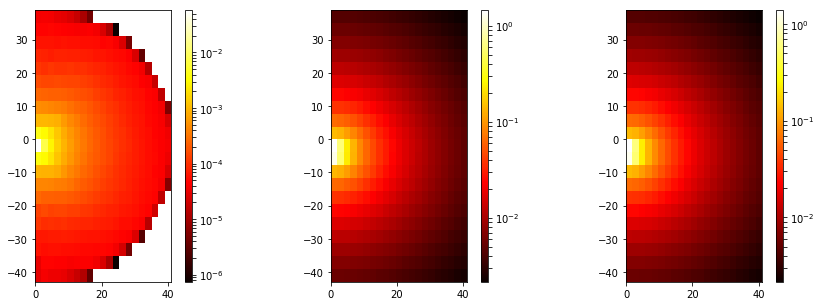

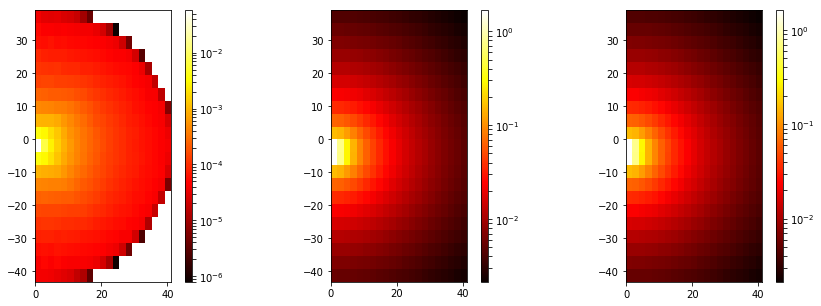

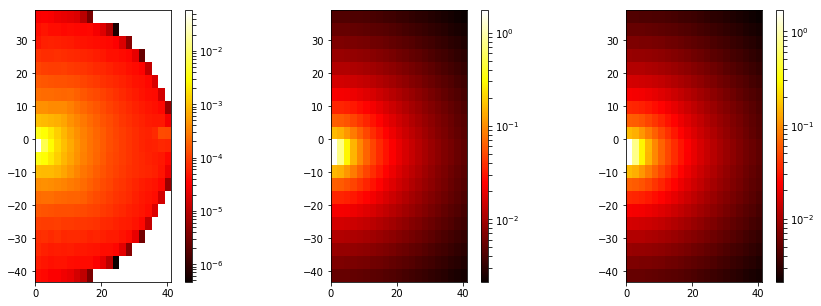

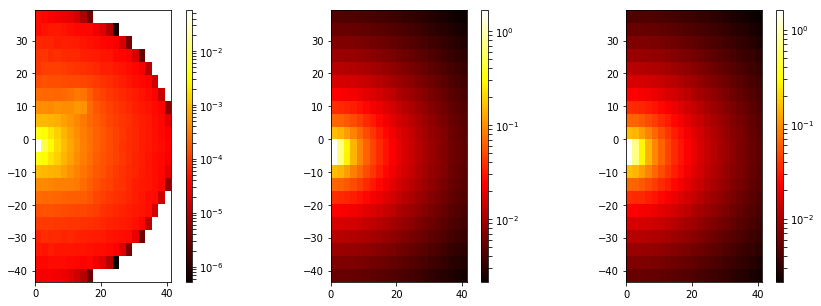

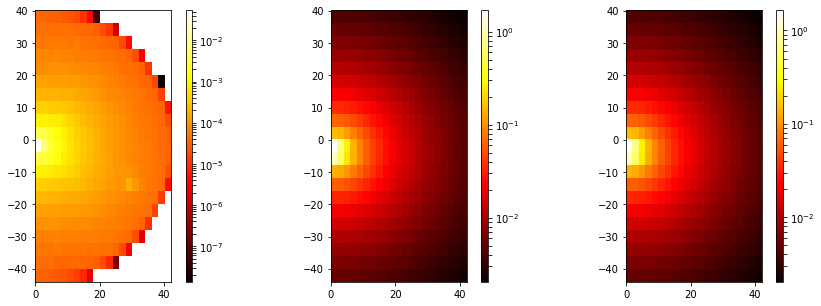

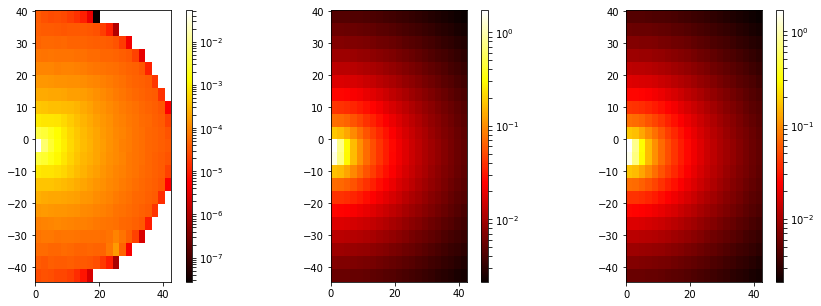

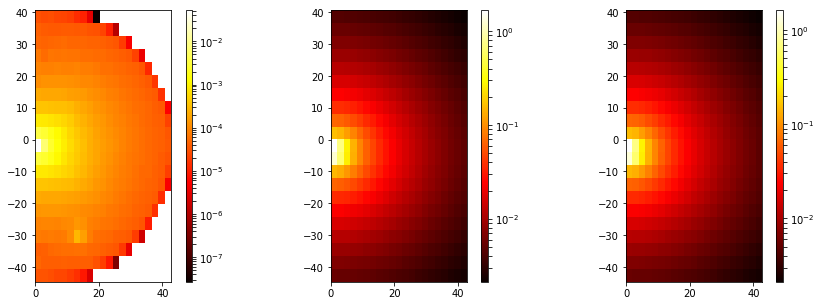

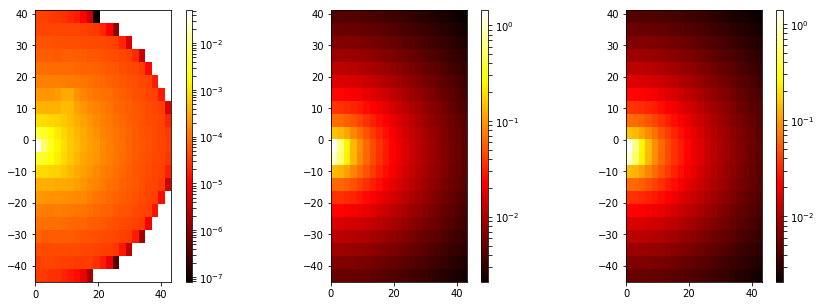

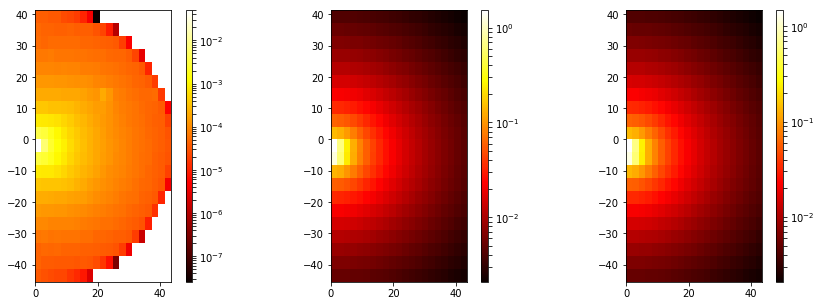

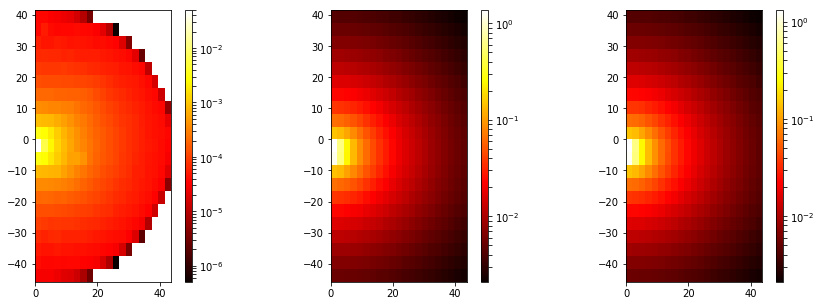

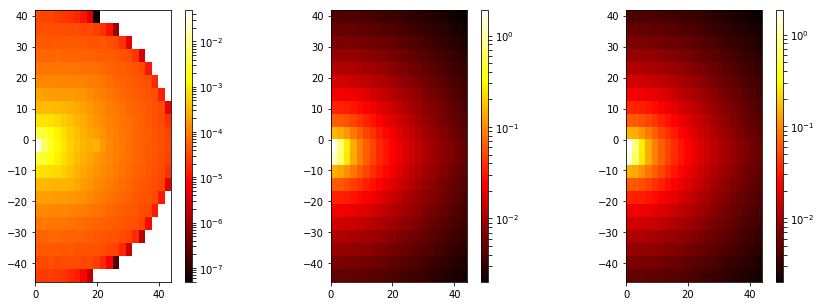

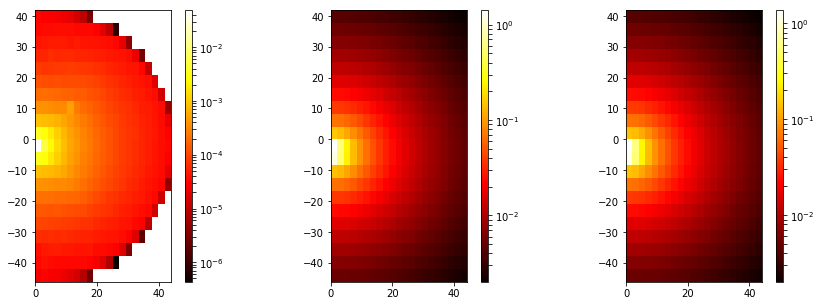

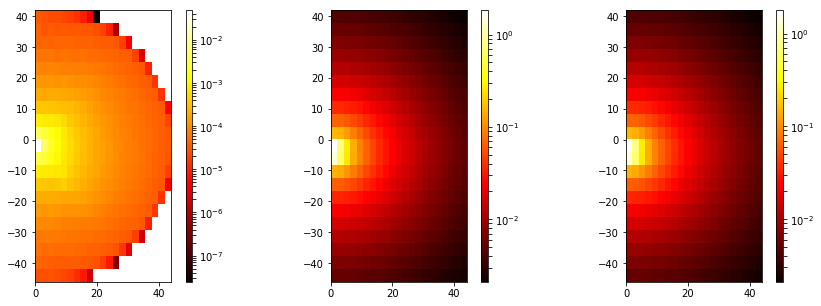

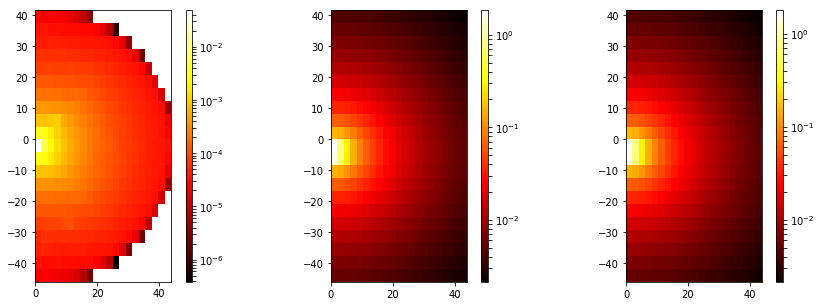

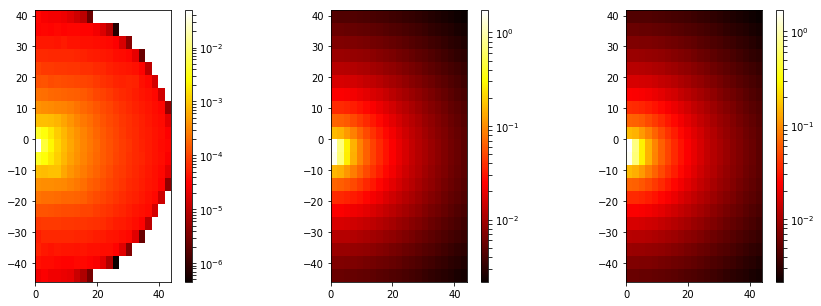

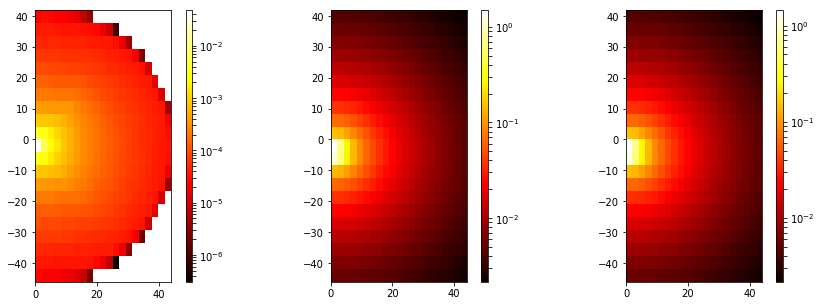

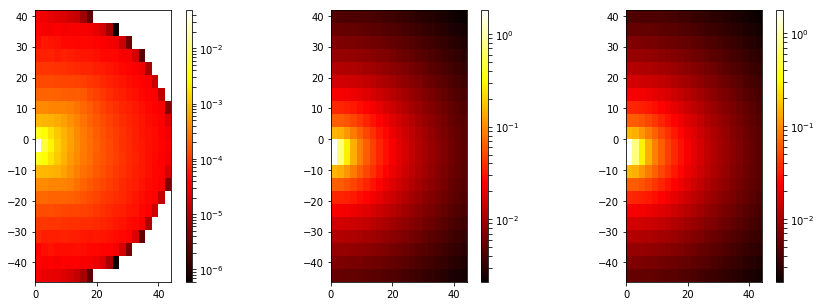

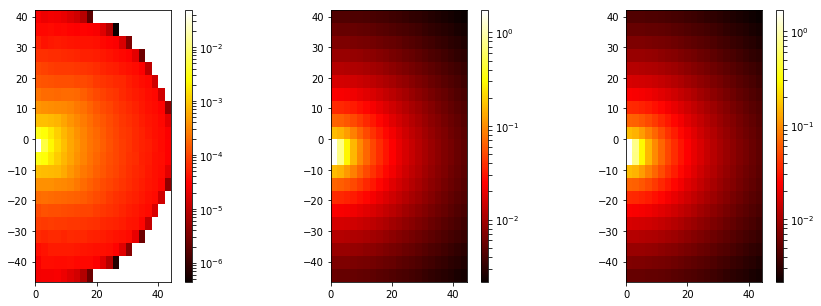

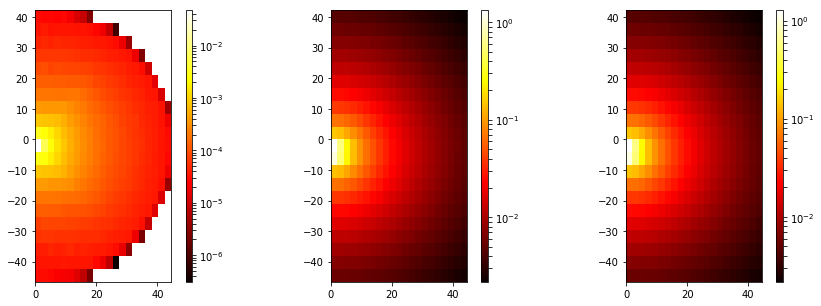

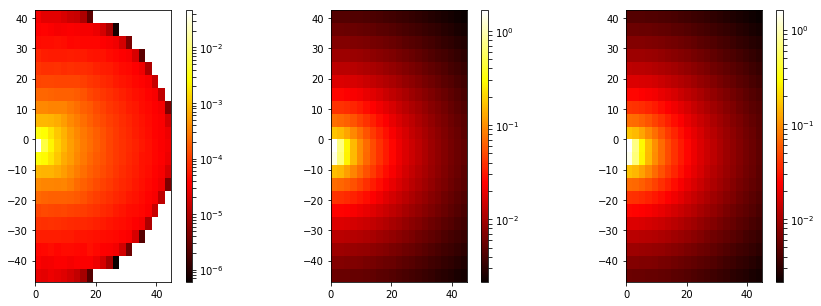

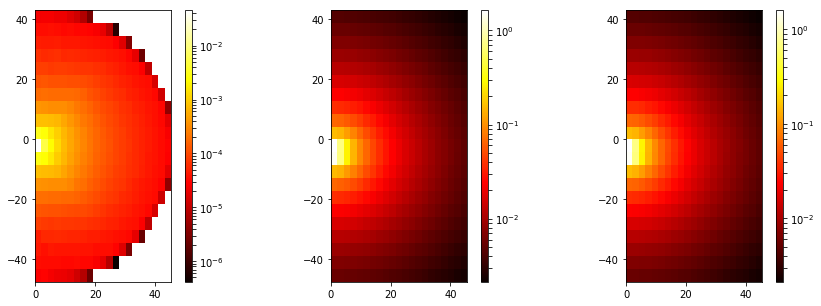

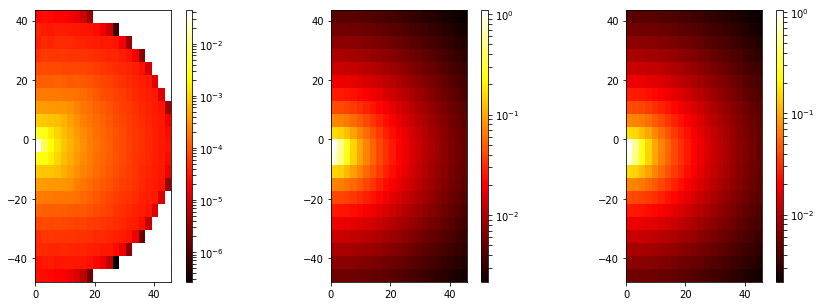

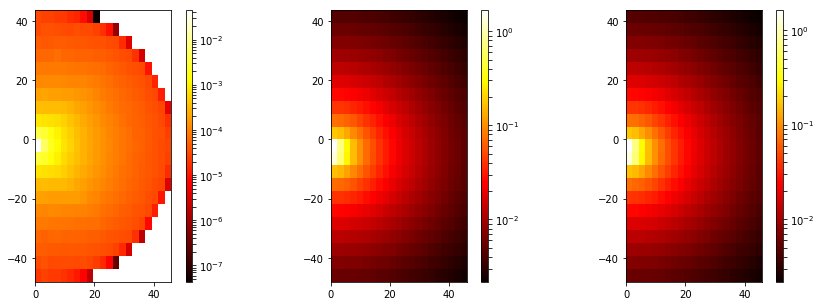

In [36]:
# check if density values agree
level = 4
halo_number = 24  # range(1, 31):
halodir = basedir + "halo_{0}/".format(halo_number)
snappath = halodir + "output/"

_REFR0_kpc =8.

for i_snap, snap in enumerate(snapnr):
    if snap < 75:
        continue
    pot = setup_galpy_potential(a_MND_kpc[i_snap], b_MND_kpc[i_snap], a_NFWH_kpc[i_snap], a_HB_kpc[i_snap], n_MND[i_snap], n_NFWH[i_snap], n_HB[i_snap]) 
    _REFV0_kms = v0_kms[i_snap]
    
    print("snapnr: {0}".format(snap))
    print(datetime.datetime.now().time())
    try:
        s1, sf1 = eat_snap_and_fof(level, halo_number, snap, snappath, loadonlytype=[1,2,3,4], 
        haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
    except KeyError:
        print('\n\n', snapnr, 'not read in.\n\n')
        continue
    # Clean negative and zero values of gmet to avoid RuntimeErrors
    # later on (e.g. dividing by zero)
    #s1.data['gmet'] = np.maximum( s1.data['gmet'], 1e-40 ) 
    
    mask = np.where((s1.halo == 0) & (s1.r() < 2. * s1.galrad) & (s1.r() > 0.) )#& (s1.type == 4) )
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s1, sf1, mask)

    M_10Msol = s1.mass[mask]
    dR_kpc, dz_kpc = 2000. * s1.galrad / 21., 4000. * s1.galrad/21.
    print(datetime.datetime.now().time())
    print('start data density calculation')
    rho, R_kpc_binned, z_kpc_binned, vol_binned = dens(M_10Msol, R_kpc, z_kpc, dR_kpc, dz_kpc)
    
    #evaluateDensities(pot, R, z)
    print(datetime.datetime.now().time())
    print('start fitted density calculation')
    densities = np.zeros((len(z_kpc_binned), len(R_kpc_binned)))
    for i in range(len(z_kpc_binned)):
        for j in range(len(R_kpc_binned)):    
            densities[i,j] = evaluateDensities(pot, R_kpc_binned[j] / _REFR0_kpc, z_kpc_binned[i]/ _REFR0_kpc) * bovy_conversion.dens_in_msolpc3(_REFV0_kms,_REFR0_kpc) * 10. # in 10^10 M_sol / kpc^3

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    x, y, z = R_kpc_binned, z_kpc_binned, rho
    im1 = ax1.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.2)
    cbar1 = fig.colorbar(im1, cax=cax1)
    
    x, y, z = R_kpc_binned, z_kpc_binned, densities

    im2 = ax2.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax2)
    cax2 = divider.append_axes("right", size="5%", pad=0.2)
    cbar2 = fig.colorbar(im2, cax=cax2)
    
    x, y, z = R_kpc_binned, z_kpc_binned, (densities-rho)
    im3 = ax3.imshow(z, extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)),
            cmap=cm.hot, norm=LogNorm())
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes("right", size="5%", pad=0.2)
    cbar3 = fig.colorbar(im3, cax=cax3)
    display(fig)
    

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

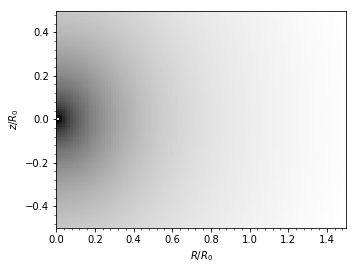

In [9]:
plotDensities(pot,nrs=101,nzs=101, log = True)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/PowerSphericalPotentialwCutoff.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  return 1./r**self.alpha*nu.exp(-(r/self.rc)**2.)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: Run

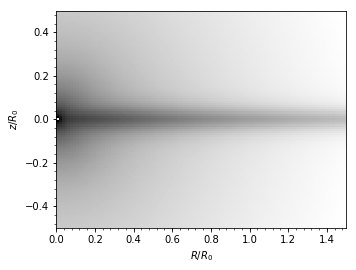

In [35]:
plotDensities(MWPotential2014,nrs=101,nzs=101, log = True)